# Машинное обучение, ФКН ВШЭ

## Практическое задание 3. Градиентный спуск своими руками

### Общая информация
Дата выдачи: **23.10.2023**

Мягкий дедлайн: **08.11.23 23:59**

Жесткий дедлайн: **12.11.23 23:59**

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов + 2 балла бонус.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо считываемые диаграммы.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-03-gd-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 11.5


Напомним, что на лекциях и семинарах мы разбирали некоторые подходы к оптимизации функционалов по параметрам. В частности, был рассмотрен градиентный спуск и различные подходы к его реализации — полный градиентный спуск, стохастический градиентный спуск, метод импульса и другие. В качестве модели у нас будет выступать линейная регрессия.

В этом домашнем задании вам предстоит реализовать 4 различных вариации градиентного спуска, написать свою реализацию линейной регресии, сравнить методы градиентного спуска между собой на реальных данных и ещё много чего веселого и интересного!

## Задание 1. Реализация градиентного спуска (3.5 балла)

В этом задании вам предстоит написать собственные реализации различных подходов к градиентному спуску с опорой на подготовленные шаблоны в файле `descents.py`.

**Все реализуемые методы должны быть векторизованы!**

### Лирическое-теоретическое отступление № 1

Основное свойство антиградиента &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента,
пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (например, нулевой или сгенерированный из некоторого
случайного распределения). Тогда ванильный градиентный спуск состоит в повторении следующих шагов до сходимости:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

### Лирическое-теоретическое отступление № 2

На семинаре про [матрично-векторное дифференцирование](https://github.com/esokolov/ml-course-hse/blob/master/2022-fall/seminars/sem03-vector-diff.pdf) вы должны были обсуждать дифференцирование функции потерь MSE в матричном виде.

### Задание 1.0. Градиент MSE в матричном виде (0 баллов).

Напомним, что функция потерь MSE записывается в матричном виде как:

$$
    Q(w) = \dfrac{1}{\ell} \left( y - Xw \right)^T \left( y - Xw \right)
$$

Выпишите ниже (подсмотрев в семинар или решив самостоятельно) градиент для функции потерь MSE в матричном виде.

$$
\nabla_{\mathbf{w}} \text{MSE} = \frac{2}{\ell} \mathbf{X}^\top(\mathbf{Xw} - \mathbf{y})
$$

### Задание 1.1. Родительский класс BaseDescent (0.5 балла).

Реализуйте функции `calc_loss` (вычисление MSE для переданных $x$ и $y$) и `predict` (предсказание $y_{pred}$ для переданных $x$) в классе `BaseDescent`.

Все вычисления должны быть векторизованы.

In [1]:
from dataclasses import dataclass
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type

import numpy as np


@dataclass
class LearningRate:
    lambda_: float = 1e-3
    s0: float = 1
    p: float = 0.5

    iteration: int = 0

    def __call__(self):
        """
        Calculate learning rate according to lambda (s0/(s0 + t))^p formula
        """
        self.iteration += 1
        return self.lambda_ * (self.s0 / (self.s0 + self.iteration)) ** self.p


class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()


class BaseDescent:
    """
    A base class and templates for all functions
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Template for update_weights function
        Update weights with respect to gradient
        :param gradient: gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        pass

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Template for calc_gradient function
        Calculate gradient of loss function with respect to weights
        :param x: features array
        :param y: targets array
        :return: gradient: np.ndarray
        """
        pass

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        loss = np.mean(np.square(y - x @ self.w))
        return loss

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        y_pred = x @ self.w
        return y_pred


### Задание 1.2. Полный градиентный спуск VanillaGradientDescent (0.5 балла).

Реализуйте полный градиентный спуск заполнив пропуски в классе `VanillaGradientDescent` в файле `descents.py`. Для вычисления градиента используйте формулу выше. Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

Здесь и далее функция `update_weights` должна возвращать разницу между $w_{k + 1}$ и $w_{k}$: $\quad w_{k + 1} - w_{k} = -\eta_{k} \nabla_{w} Q(w_{k})$.

Во всех методах градиентного спуска мы будем использовать следующую формулу для длины шага:

$$
    \eta_{k} = \lambda \left(\dfrac{s_0}{s_0 + k}\right)^p
$$

На практике достаточно настроить параметр $\lambda$, а остальным выставить параметры по умолчанию: $s_0 = 1, \, p = 0.5.$

In [2]:
class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        weight_difference = -self.lr() * gradient
        self.w += weight_difference
        return weight_difference

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        gradient = (2 / x.shape[0]) * (x.T.dot(x.dot(self.w) - y))
        return gradient

### Лирическое-теоретическое отступление № 3

Как правило, в задачах машинного обучения функционал $Q(w)$ представим в виде суммы $\ell$ функций:

$$
    Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        q_i(w).
$$

В нашем домашнем задании отдельные функции $q_i(w)$ соответствуют ошибкам на отдельных объектах.

Проблема метода градиентного спуска состоит в том, что на каждом шаге необходимо вычислять градиент всей суммы (будем его называть полным градиентом):

$$
    \nabla_w Q(w)
    =
    \frac{1}{\ell}
    \sum_{i = 1}^{\ell}
        \nabla_w q_i(w).
$$

Это может быть очень трудоёмко при больших размерах выборки. В то же время точное вычисление градиента может быть не так уж необходимо &ndash; как правило, мы делаем не очень большие шаги в сторону антиградиента, и наличие в нём неточностей не должно сильно сказаться на общей траектории.

Оценить градиент суммы функций можно средним градиентов случайно взятого подмножества функций:

$$
    \nabla_{w} Q(w_{k}) \approx \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}),
$$
где $B$ - это случайно выбранное подмножество индексов.

В этом случае мы получим метод **стохастического градиентного спуска**.

### Задание 1.3. Стохастический градиентный спуск StochasticDescent (0.5 балла).

Реализуйте стохастический градиентный спуск заполнив пропуски в классе `StochasticDescent`. Для оценки градиента используйте формулу выше (среднее градиентов случайно выбранного батча объектов). Шаг оптимизации:

$$
    w_{k + 1} = w_{k} - \eta_{k} \dfrac{1}{|B|}\sum\limits_{i \in B}\nabla_{w} q_{i}(w_{k}).
$$

Размер батча будет являться гиперпараметром метода, семплируйте индексы для батча объектов с помощью `np.random.randint`.

In [3]:
class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
      indices = np.random.choice(range(len(y)), size = self.batch_size, replace=False)
      x_batch = x[indices]
      y_batch = y[indices]
      gradient = (2 / self.batch_size) * x_batch.T.dot(x_batch.dot(self.w) - y_batch)
      return gradient


### Лирическое-теоретическое отступление № 4

Может оказаться, что направление антиградиента сильно меняется от шага к шагу. Например, если линии уровня функционала сильно вытянуты, то из-за ортогональности градиента линиям уровня он будет менять направление на почти противоположное на каждом шаге. Такие осцилляции будут вносить сильный шум в движение, и процесс оптимизации займёт много итераций. Чтобы избежать этого, можно усреднять векторы антиградиента с нескольких предыдущих шагов &ndash; в этом случае шум уменьшится, и такой средний вектор будет указывать в сторону общего направления движения. Введём для этого вектор инерции:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k})
\end{align}

Здесь $\alpha$ &ndash; параметр метода, определяющей скорость затухания градиентов с предыдущих шагов. Разумеется, вместо вектора градиента может быть использована его аппроксимация. Чтобы сделать шаг градиентного спуска, просто сдвинем предыдущую точку на вектор инерции:

$$
    w_{k + 1} = w_{k} - h_{k + 1}.
$$

Заметим, что если по какой-то координате градиент постоянно меняет знак, то в результате усреднения градиентов в векторе инерции эта координата окажется близкой к нулю. Если же по координате знак градиента всегда одинаковый, то величина соответствующей координаты в векторе инерции будет большой, и мы будем делать большие шаги в соответствующем направлении.

### Задание 1.4 Метод Momentum MomentumDescent (0.5 балла).

Реализуйте градиентный спуск с методом инерции заполнив пропуски в классе `MomentumDescent`. Шаг оптимизации:

\begin{align}
    &h_0 = 0, \\
    &h_{k + 1} = \alpha h_{k} + \eta_k \nabla_w Q(w_{k}) \\
    &w_{k + 1} = w_{k} - h_{k + 1}.
\end{align}

$\alpha$ будет являться гиперпараметром метода, но в данном домашнем задании мы зафиксируем её за вас $\alpha = 0.9$.

In [4]:
class MomentumDescent(VanillaGradientDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.h = self.alpha * self.h  - self.lr()  * gradient
        weight_difference = self.h
        self.w += weight_difference
        return weight_difference

### Лирическое-теоретическое отступление № 5

Градиентный спуск очень чувствителен к выбору длины шага. Если шаг большой, то есть риск, что мы будем перескакивать через точку минимума; если же шаг маленький, то для нахождения минимума потребуется много итераций. При этом нет способов заранее определить правильный размер шага &ndash; к тому же, схемы с постепенным уменьшением шага по мере итераций могут тоже плохо работать.

В методе AdaGrad предлагается сделать свою длину шага для каждой компоненты вектора параметров. При этом шаг будет тем меньше, чем более длинные шаги мы делали на предыдущих итерациях:

\begin{align}
    &G_{kj} = G_{k-1,j} + (\nabla_w Q(w_{k - 1}))_j^2; \\
    &w_{jk} = w_{j,k-1} - \frac{\eta_t}{\sqrt{G_{kj}} + \varepsilon} (\nabla_w Q(w_{k - 1}))_j.
\end{align}

Здесь $\varepsilon$ небольшая константа, которая предотвращает деление на ноль.

В данном методе можно зафксировать длину шага (например, $\eta_k = 0.01$) и не подбирать её в процессе обучения. Отметим, что данный метод подходит для разреженных задач, в которых у каждого объекта большинство признаков равны нулю. Для признаков, у которых ненулевые значения встречаются редко, будут делаться большие шаги; если же какой-то признак часто является ненулевым, то шаги по нему будут небольшими.

У метода AdaGrad есть большой недостаток: переменная $G_{kj}$ монотонно растёт, из-за чего шаги становятся всё медленнее и могут остановиться ещё до того, как достигнут минимум функционала. Проблема решается в методе RMSprop, где используется экспоненциальное затухание градиентов:

$$
    G_{kj} = \alpha G_{k-1,j} + (1 - \alpha) (\nabla_w Q(w^{(k-1)}))_j^2.
$$

В этом случае размер шага по координате зависит в основном от того, насколько
быстро мы двигались по ней на последних итерациях.

Можно объединить идеи описанных выше методов: накапливать градиенты со всех прошлых шагов для
избежания осцилляций и делать адаптивную длину шага по каждому параметру.

### Задание 1.5. Метод Adam (Adaptive Moment Estimation) (1.5 балла).

![](adam_meme.png)

Реализуйте градиентный спуск с методом Adam заполнив пропуски в классе `Adam`. Шаг оптимизации:

\begin{align}
    &m_0 = 0, \quad v_0 = 0; \\ \\
    &m_{k + 1} = \beta_1 m_k + (1 - \beta_1) \nabla_w Q(w_{k}); \\ \\
    &v_{k + 1} = \beta_2 v_k + (1 - \beta_2) \left(\nabla_w Q(w_{k})\right)^2; \\ \\
    &\widehat{m}_{k} = \dfrac{m_k}{1 - \beta_1^{k}}, \quad \widehat{v}_{k} = \dfrac{v_k}{1 - \beta_2^{k}}; \\ \\
    &w_{k + 1} = w_{k} - \dfrac{\eta_k}{\sqrt{\widehat{v}_{k + 1}} + \varepsilon} \widehat{m}_{k + 1}.
\end{align}

$\beta_1 = 0.9, \beta_2 = 0.999$ и $\varepsilon = 10^{-8}$ будут зафиксированы за вас.

In [5]:
class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.iteration += 1
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradient
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * np.square(gradient)
        m_hat = self.m / (1 - self.beta_1 ** self.iteration)
        v_hat = self.v / (1 - self.beta_2 ** self.iteration)
        weight_difference = - (self.lr() / (np.sqrt(v_hat) + self.eps)) * m_hat
        self.w += weight_difference
        return weight_difference


## Задание 2. Реализация линейной регресии (0.5 балла)

В этом задании вам предстоит написать свою реализацию линейной регресии, обучаемой с использованием градиентного спуска, с опорой на подготовленные шаблоны в файле `linear_regression.py` - **LinearRegression**. По сути линейная регрессия будет оберткой, которая запускает обучение

Необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускаются только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):
    * Квадрат евклидовой нормы разности весов на двух соседних итерациях меньше `tolerance`;
    * Разность весов содержит наны;
    * Достижение максимального числа итераций `max_iter`.
* Будем считать, что все данные, которые поступают на вход имеют столбец единичек последним столбцом;
* Чтобы проследить за сходимостью оптимизационного процесса будем использовать `loss_history`, в нём будем хранить значения функции потерь до каждого шага, начиная с нулевого (до первого шага по антиградиенту) и значение функции потерь после оптимизации.

In [6]:
from __future__ import annotations

from typing import List

import numpy as np

from descents import BaseDescent
from descents import get_descent


class LinearRegression:
    """
    Linear regression class
    """

    def __init__(self, descent_config: dict, tolerance: float = 1e-4, max_iter: int = 300):
        """
        :param descent_config: gradient descent config
        :param tolerance: stopping criterion for square of euclidean norm of weight difference (float)
        :param max_iter: stopping criterion for iterations (int)
        """
        self.descent: BaseDescent = get_descent(descent_config)

        self.tolerance: float = tolerance
        self.max_iter: int = max_iter

        self.loss_history: List[float] = []

    def fit(self, x: np.ndarray, y: np.ndarray) -> LinearRegression:
        """
        Fitting descent weights for x and y dataset
        :param x: features array
        :param y: targets array
        :return: self
        """
        count = 0
        self.loss_history.append(self.descent.calc_loss(x, y))
        while(count < self.max_iter):
            count += 1
            gradient = self.descent.calc_gradient(x, y)
            weight_difference = self.descent.update_weights(gradient)
            loss = self.descent.calc_loss(x, y) 
            self.loss_history.append(loss)
            if np.linalg.norm(weight_difference) ** 2 < self.tolerance:
                break
            if np.isnan(weight_difference).any():
                break
        loss = self.descent.calc_loss(x, y)
        
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Predicting targets for x dataset
        :param x: features array
        :return: prediction: np.ndarray
        """
        return self.descent.predict(x)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculating loss for x and y dataset
        :param x: features array
        :param y: targets array
        """
        return self.descent.calc_loss(x, y)

## Задание 3. Проверка кода (0 баллов)

In [7]:
%load_ext autoreload

In [8]:
%autoreload 2

import numpy as np

from descents import get_descent
from linear_regression import LinearRegression

In [9]:
num_objects = 100
dimension = 5

x = np.random.rand(num_objects, dimension)
y = np.random.rand(num_objects)

In [10]:
# Descents

descent_config = {
    'descent_name': 'some name that we will replace in the future',
    'kwargs': {
        'dimension': dimension
    }
}

for descent_name in ['full', 'stochastic', 'momentum', 'adam']:
    descent_config['descent_name'] = descent_name
    descent = get_descent(descent_config)

    diff = descent.step(x, y)
    gradient = descent.calc_gradient(x, y)
    predictions = descent.predict(x)

    assert gradient.shape[0] == dimension, f'Gradient failed for descent {descent_name}'
    assert diff.shape[0] == dimension, f'Weights failed for descent {descent_name}'
    assert predictions.shape == y.shape, f'Prediction failed for descent {descent_name}'

In [11]:
# LinearRegression

max_iter = 10
tolerance = 0

descent_config = {
    'descent_name': 'stochastic',
    'kwargs': {
        'dimension': dimension,
        'batch_size': 10
    }
}

regression = LinearRegression(
    descent_config=descent_config,
    tolerance=tolerance,
    max_iter=max_iter
)

regression.fit(x, y)

assert len(regression.loss_history) == max_iter + 1, 'Loss history failed'

Если ваше решение прошло все тесты локально, то теперь пришло время протестировать его в [Яндекс Контесте](https://contest.yandex.ru/contest/54610/).

Для каждой задачи из контеста вставьте ссылку на успешную посылку:

* **VanillaGradientDescent**: https://contest.yandex.ru/contest/54610/run-report/96318806/


* **StochasticDescent**: https://contest.yandex.ru/contest/54610/run-report/96318843/


* **MomentumDescent**: https://contest.yandex.ru/contest/54610/run-report/96318891/ 


* **Adam**: https://contest.yandex.ru/contest/54610/run-report/96318947/ 


* **LinearRegression**: https://contest.yandex.ru/contest/54610/run-report/96332394/ 

## Задание 4. Работа с данными (1 балл)

Мы будем использовать датасет объявлений по продаже машин на немецком Ebay. В задаче предсказания целевой переменной для нас будет являться цена.

* Постройте график распределения целевой переменной в данных, подумайте, нужно ли заменить её на логарифм. Присутствуют ли выбросы в данных с аномальной ценой? Если да, то удалите их из данных.

* Проведите исследование данных:
    * Проанализируйте тип столбцов, постройте графики зависимости целевой переменной от признака, распределения значений признака;
    * Подумайте, какие признаки могут быть полезными на основе этих графиков, обработайте выбросы;
    * Подумайте, какие трансформации признаков из известных вам будет уместно применить;
    * Разделите полезные признаки на категориальные, вещественные и те, которые не надо предобрабатывать.
* Разделите данные на обучающую, валидационную и тестовую выборки в отношении 8:1:1.

In [12]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from descents import get_descent
from linear_regression import LinearRegression

sns.set(style='darkgrid')

In [13]:
data = pd.read_csv('autos.csv')

In [14]:
data.head()

,brand,model,vehicleType,gearbox,fuelType,notRepairedDamage,powerPS,kilometer,autoAgeMonths,price
0,volkswagen,golf,kleinwagen,manuell,benzin,nein,75,150000,177,1500
1,skoda,fabia,kleinwagen,manuell,diesel,nein,69,90000,93,3600
2,bmw,3er,limousine,manuell,benzin,ja,102,150000,246,650
3,peugeot,2_reihe,cabrio,manuell,benzin,nein,109,150000,140,2200
4,mazda,3_reihe,limousine,manuell,benzin,nein,105,150000,136,2000


<Axes: title={'center': 'Distribution of price'}, xlabel='price', ylabel='Count'>

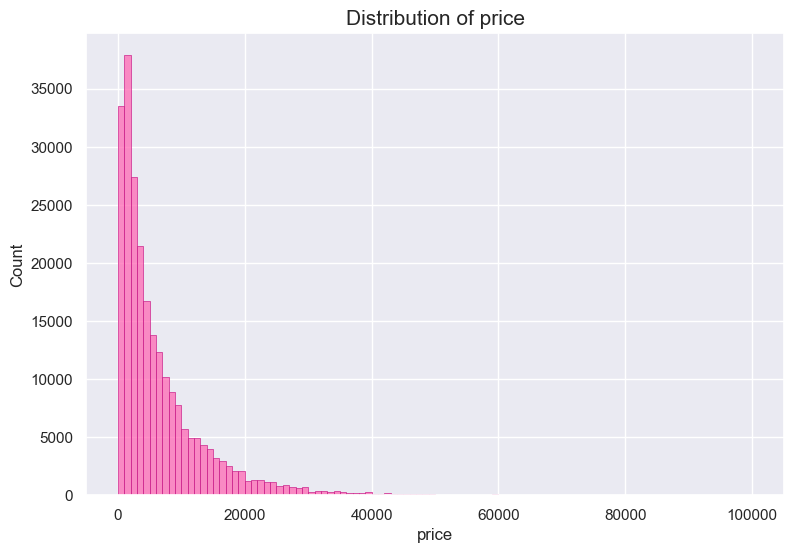

In [15]:
fig, ax = plt.subplots(figsize = (9,6))
ax.set_title('Distribution of price', fontsize = 15)
sns.histplot(data.price,
             bins = 100,
             ax=ax,
             color = 'hotpink',
             edgecolor = 'mediumvioletred')

Выбросы есть, так что заменим цену на ее логарифм и построим график нового таргета.

In [16]:
data['log_price'] = np.log1p(data['price'])
data = data.drop(['price'], axis = 1)

<Axes: title={'center': 'Distribution of price'}, xlabel='log_price', ylabel='Count'>

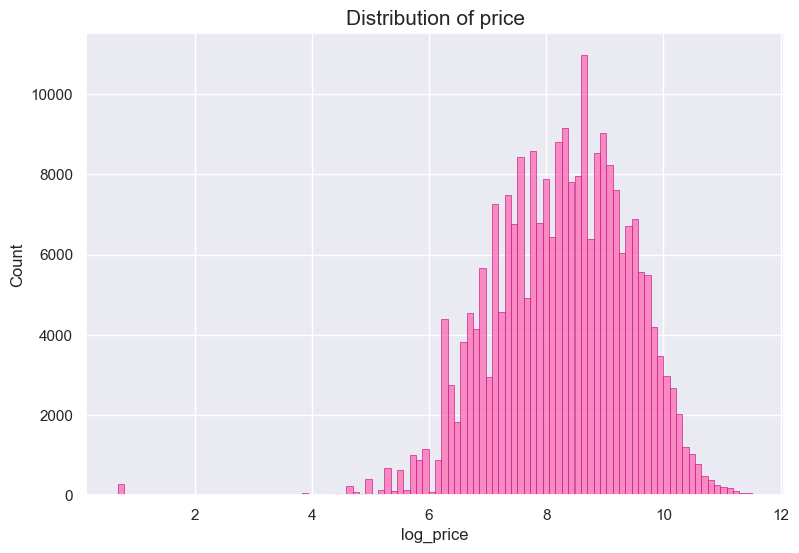

In [17]:
fig, ax = plt.subplots(figsize = (9,6))
ax.set_title('Distribution of price', fontsize = 15)
sns.histplot(data.log_price,
             bins = 100,
             ax=ax,
             color = 'hotpink',
             edgecolor = 'mediumvioletred')

Колонки в данных:

* `brand` - название бренда автомобиля
* `model` - название модели автомобиля
* `vehicleType` - тип транспортного средства
* `gearbox` - тип трансмисcии
* `fuelType` - какой вид топлива использует автомобиль
* `notRepairedDamage` - есть ли в автомобиле неисправность, которая еще не устранена
* `powerPS` - мощность автомобиля в PS (метрическая лошадиная сила)
* `kilometer` - сколько километров проехал автомобиль, пробег
* `autoAgeMonths` - возраст автомобиля в месяцах


* `price` - цена, указанная в объявлении о продаже автомобиля (целевая переменная)

In [18]:
categorical = ['brand', 'model', 'vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage']
numeric = ['powerPS', 'kilometer', 'autoAgeMonths']
other = []

# YOUR CODE (EDA):

Построим графики для категориальных признаков.

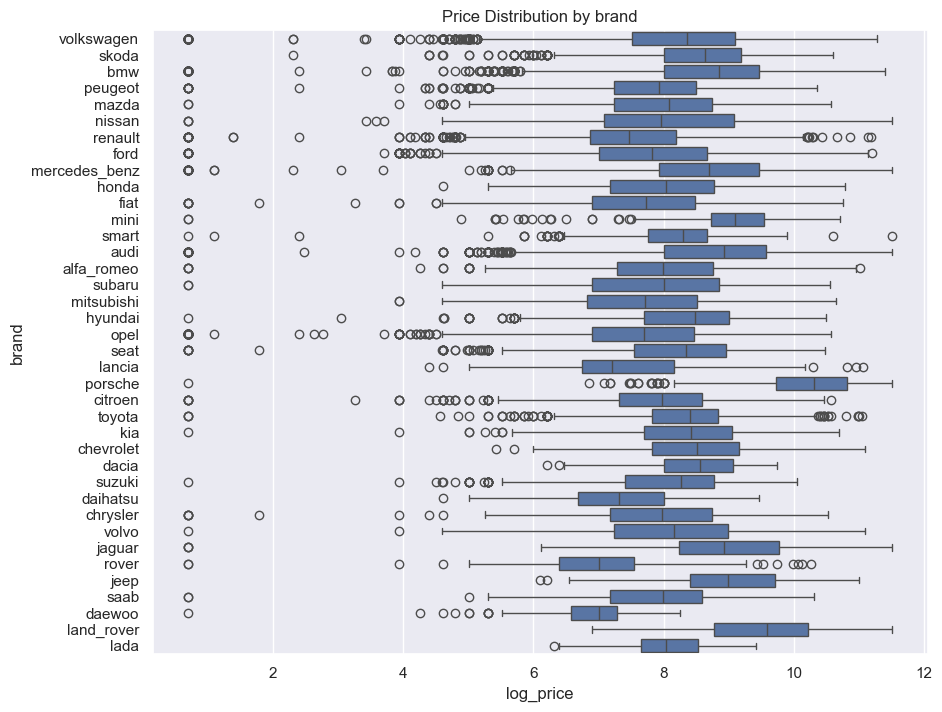

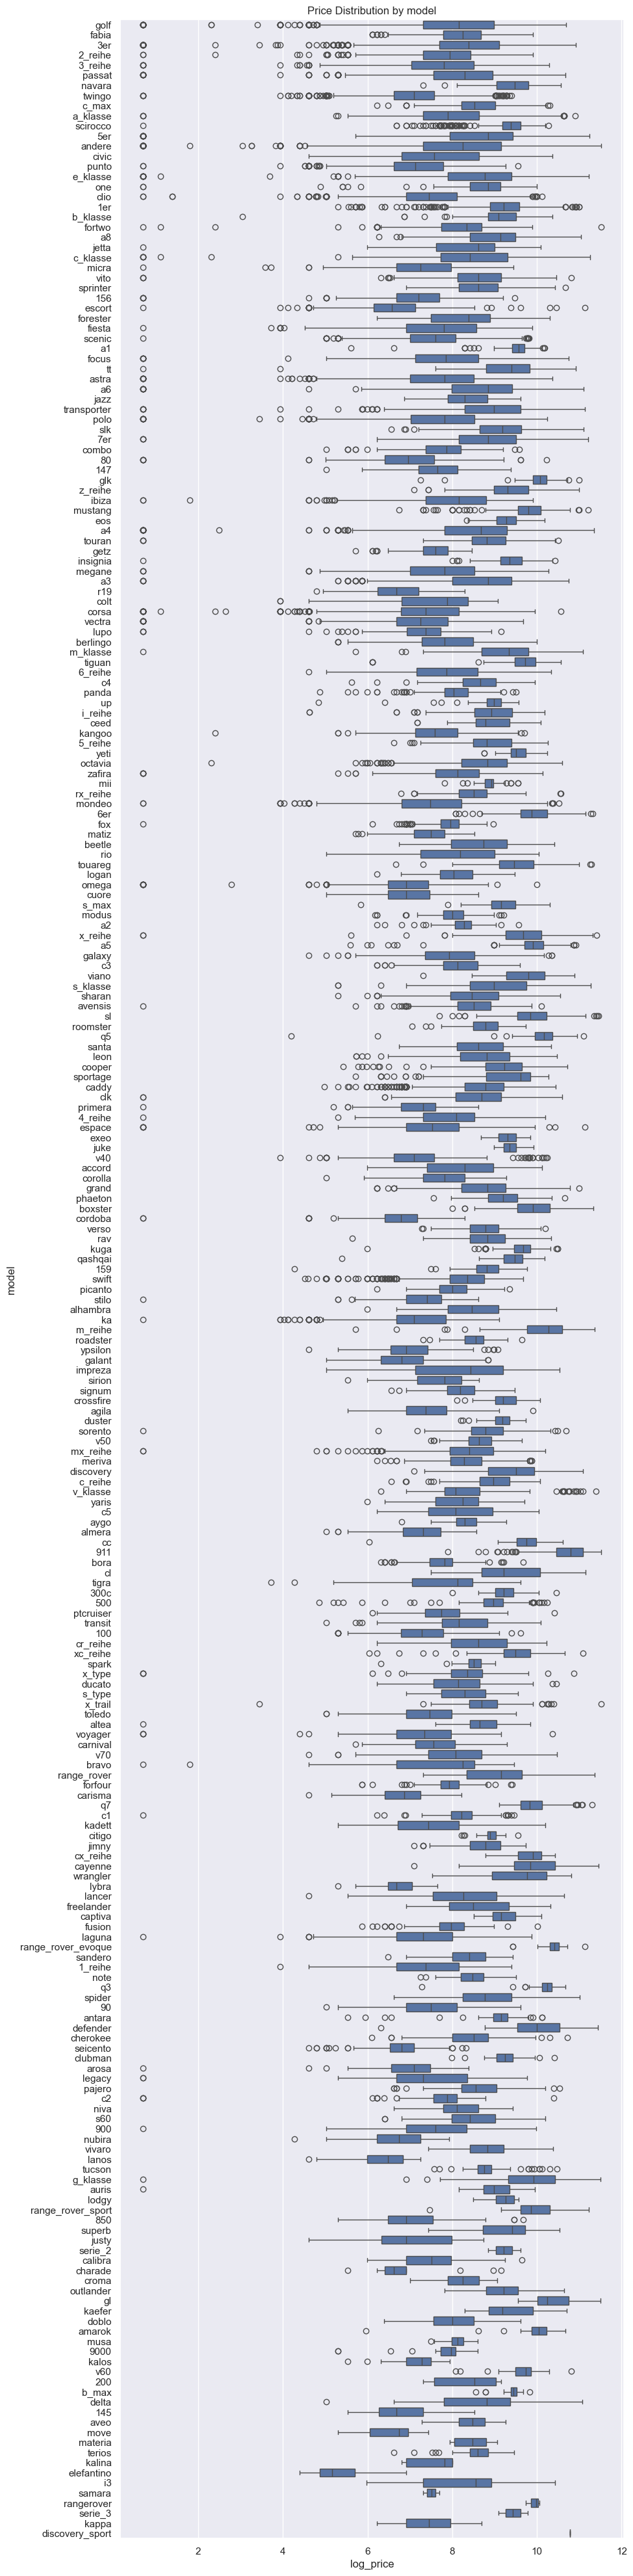

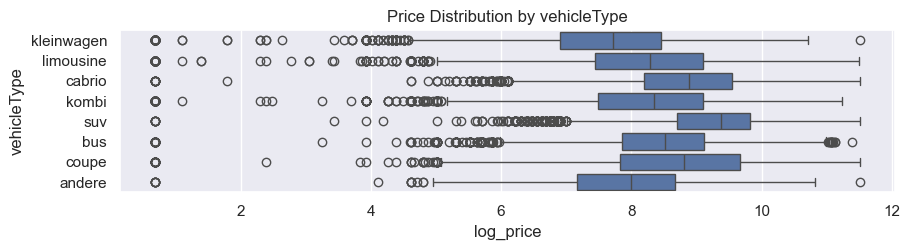

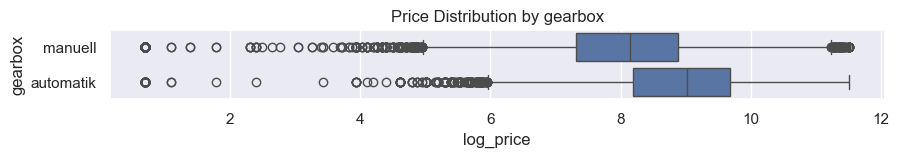

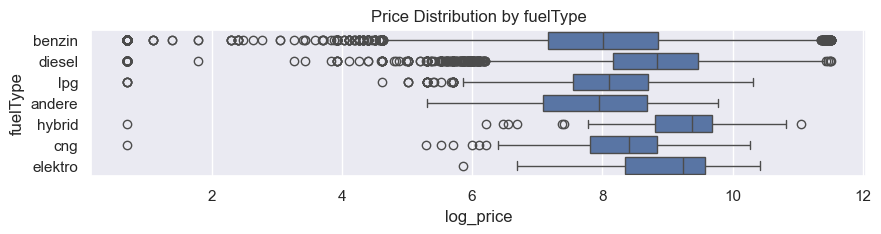

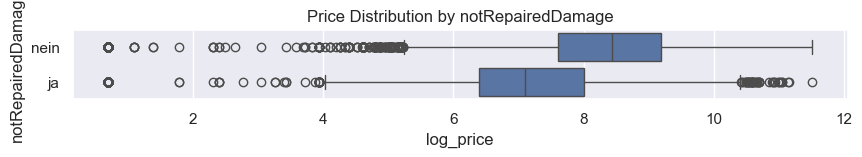

In [19]:
for feature in categorical:
    plt.figure(figsize=(10, 0.5 + 0.2*len(data[feature].unique())))
    sns.boxplot(x='log_price', y=feature, data=data)
    plt.title(f'Price Distribution by {feature}')
    plt.show()

И для количественных.

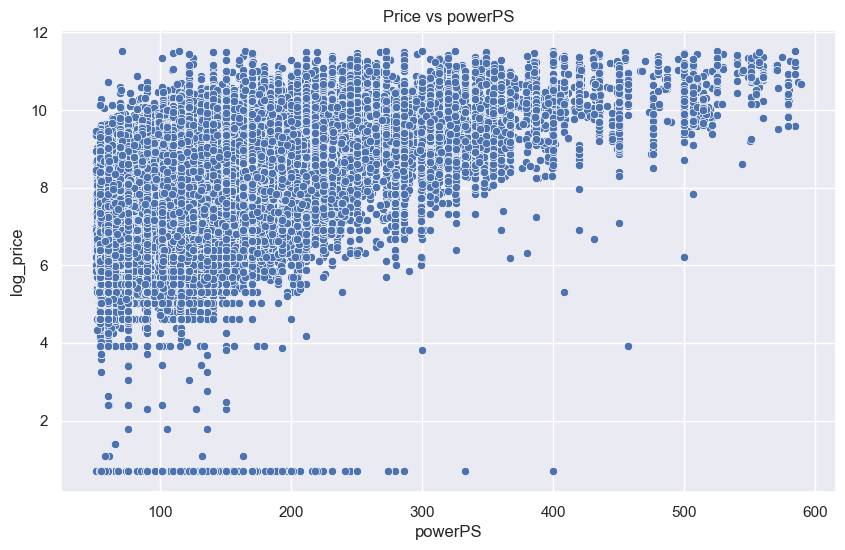

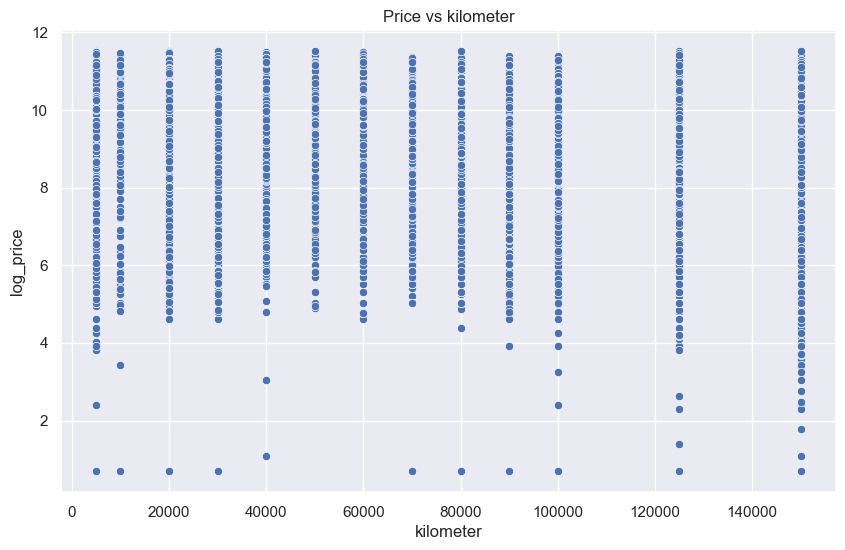

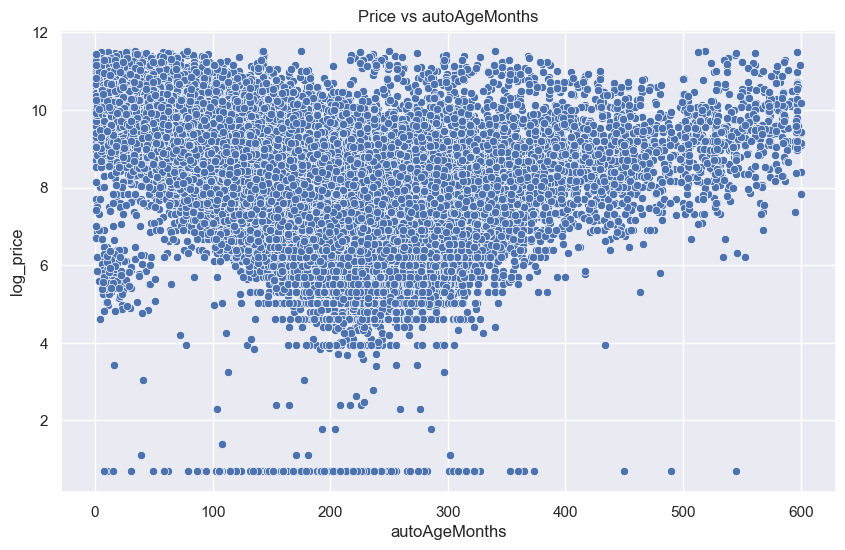

In [20]:
for feature in numeric:
    plt.figure(figsize=(10, 6))  
    sns.scatterplot(x=feature, y='log_price', data=data)
    plt.title(f'Price vs {feature}')
    plt.show()


Теперь построим графики распределения признаков.

/var/folders/4t/ljtm80j57w5122vlr3mszwdm0000gn/T/ipykernel_77218/4228693722.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


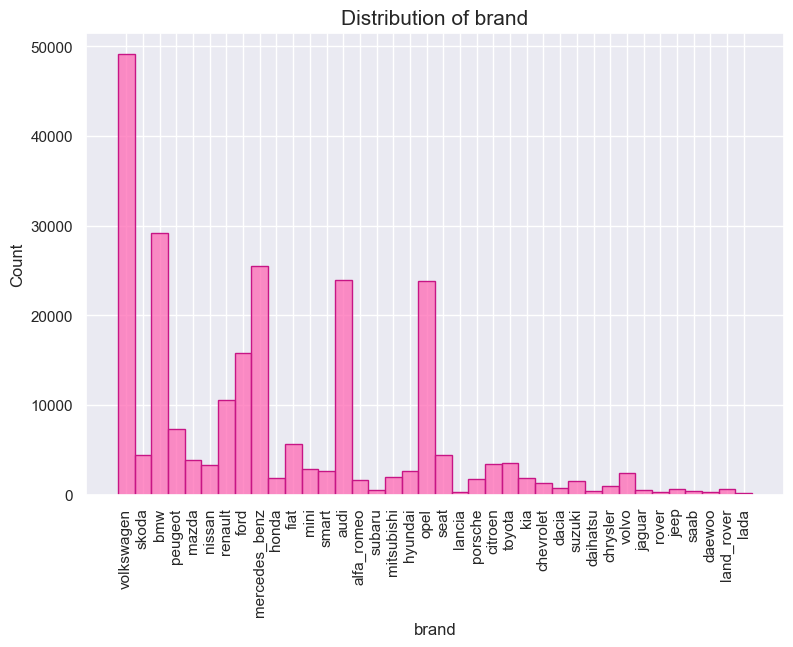

/var/folders/4t/ljtm80j57w5122vlr3mszwdm0000gn/T/ipykernel_77218/4228693722.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


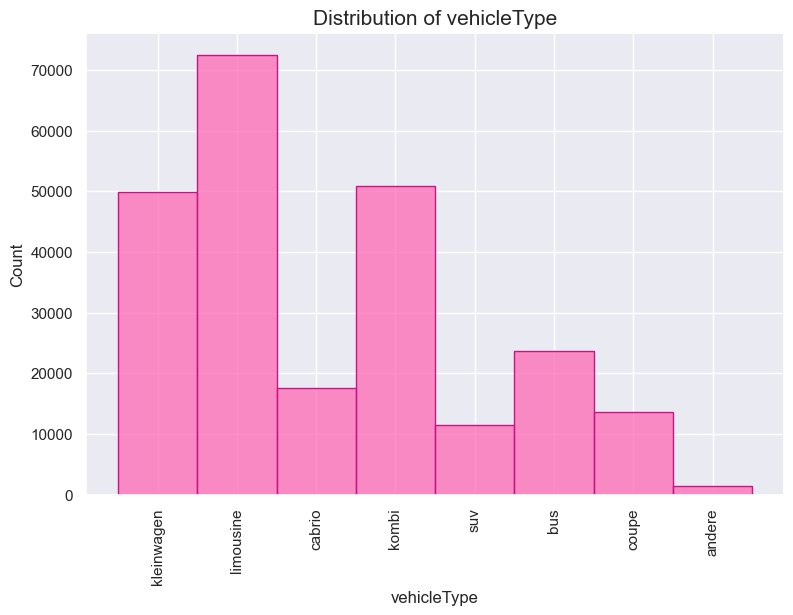

/var/folders/4t/ljtm80j57w5122vlr3mszwdm0000gn/T/ipykernel_77218/4228693722.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


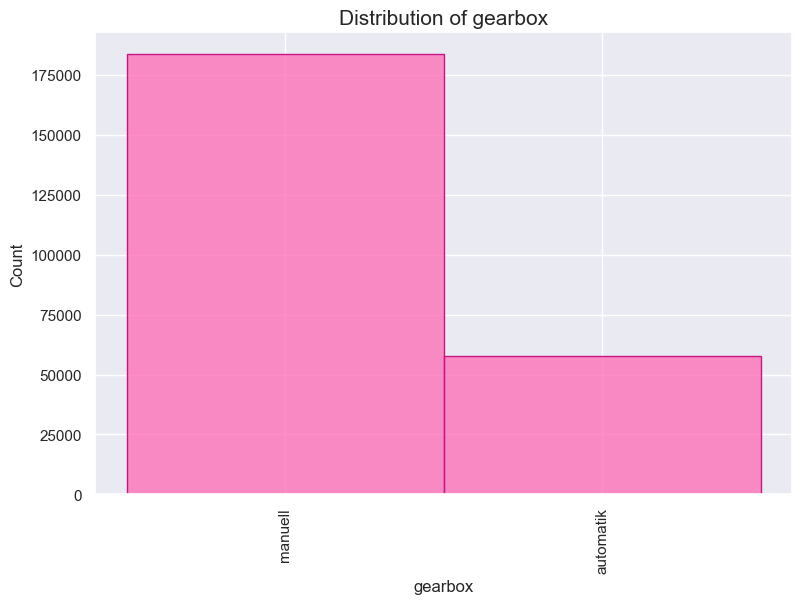

/var/folders/4t/ljtm80j57w5122vlr3mszwdm0000gn/T/ipykernel_77218/4228693722.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


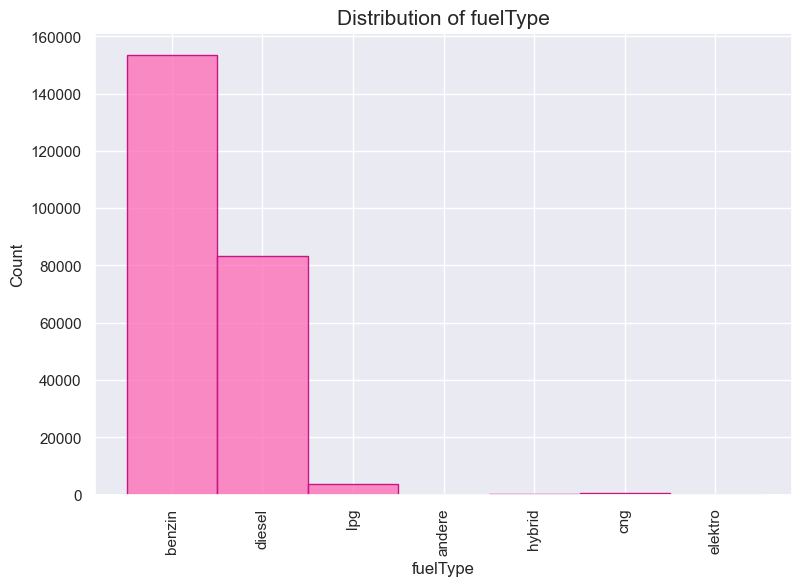

/var/folders/4t/ljtm80j57w5122vlr3mszwdm0000gn/T/ipykernel_77218/4228693722.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


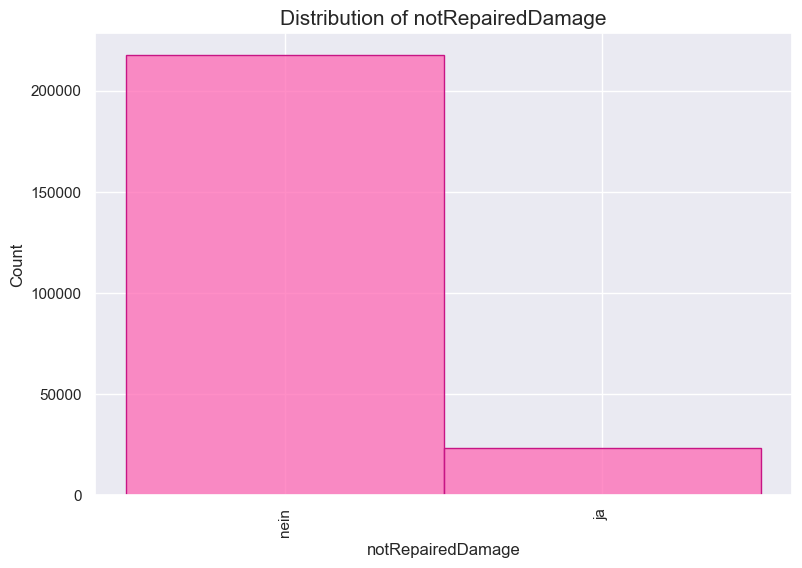

In [21]:
for feature in ['brand', 'vehicleType', 'gearbox', 'fuelType', 'notRepairedDamage']:
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_title(f'Distribution of {feature}', fontsize=15)
    sns.histplot(data=data[feature], bins=40, ax=ax, color='hotpink', edgecolor='mediumvioletred')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

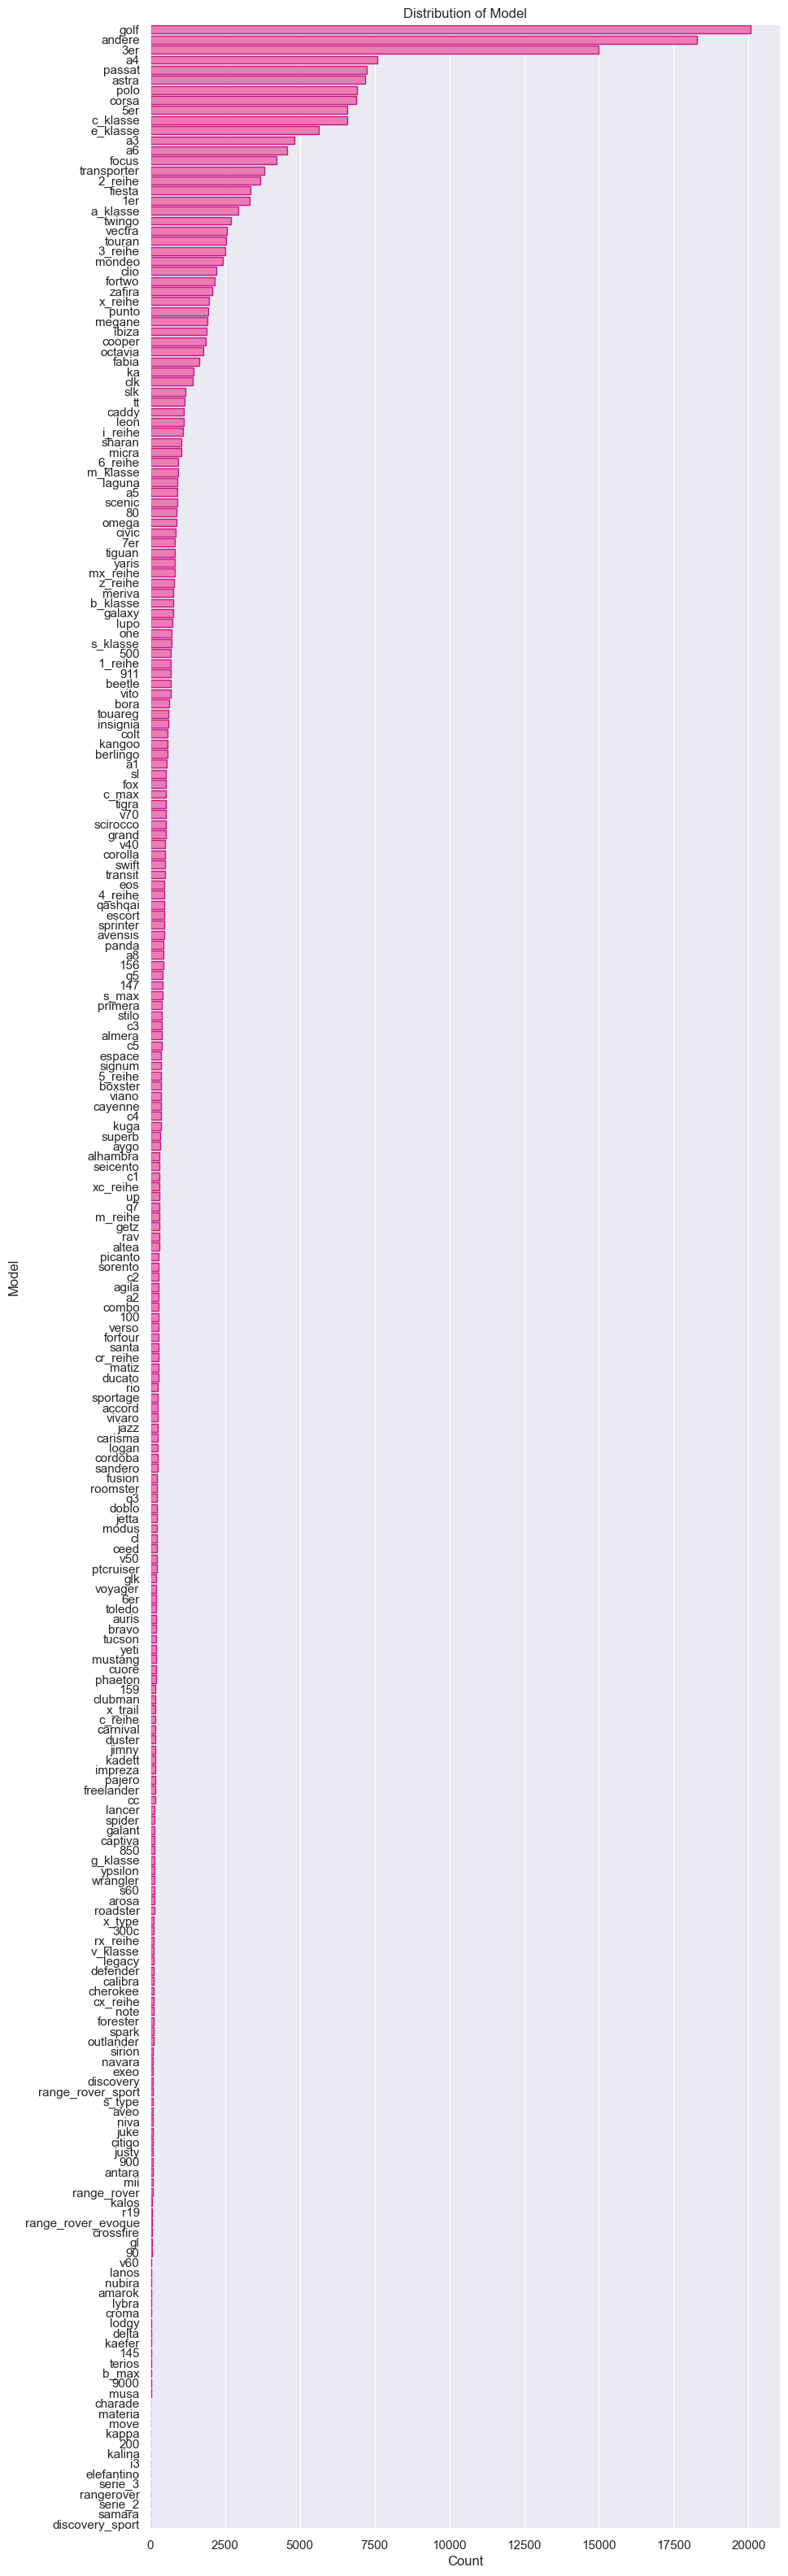

In [22]:
plt.figure(figsize=(10, 40))
sns.countplot(y='model', data=data, order=data['model'].value_counts().index, color='hotpink', edgecolor='mediumvioletred')
plt.xlabel('Count')
plt.ylabel('Model')
plt.title('Distribution of Model')
plt.show()


/var/folders/4t/ljtm80j57w5122vlr3mszwdm0000gn/T/ipykernel_77218/3871543564.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


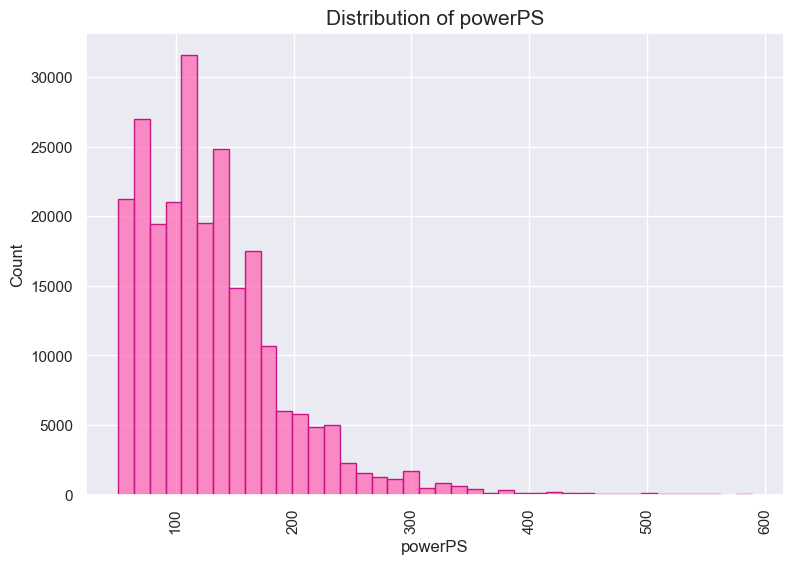

/var/folders/4t/ljtm80j57w5122vlr3mszwdm0000gn/T/ipykernel_77218/3871543564.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


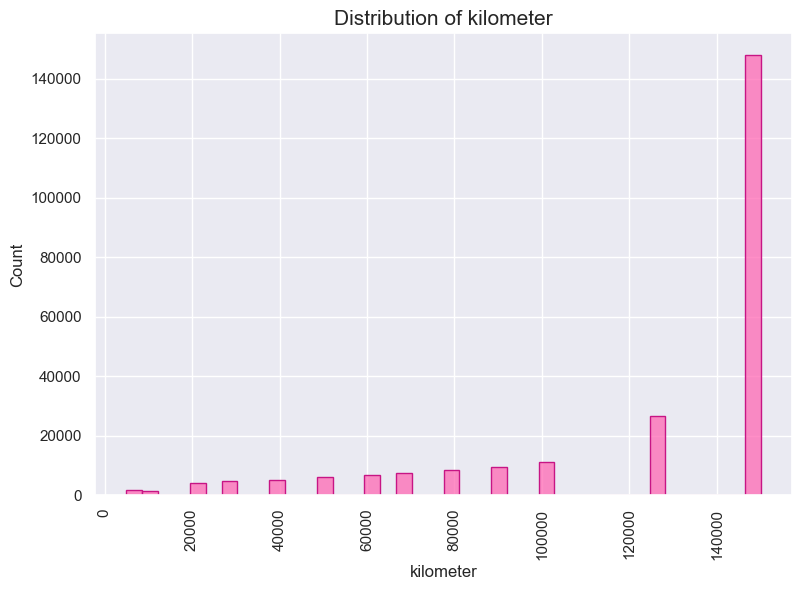

/var/folders/4t/ljtm80j57w5122vlr3mszwdm0000gn/T/ipykernel_77218/3871543564.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


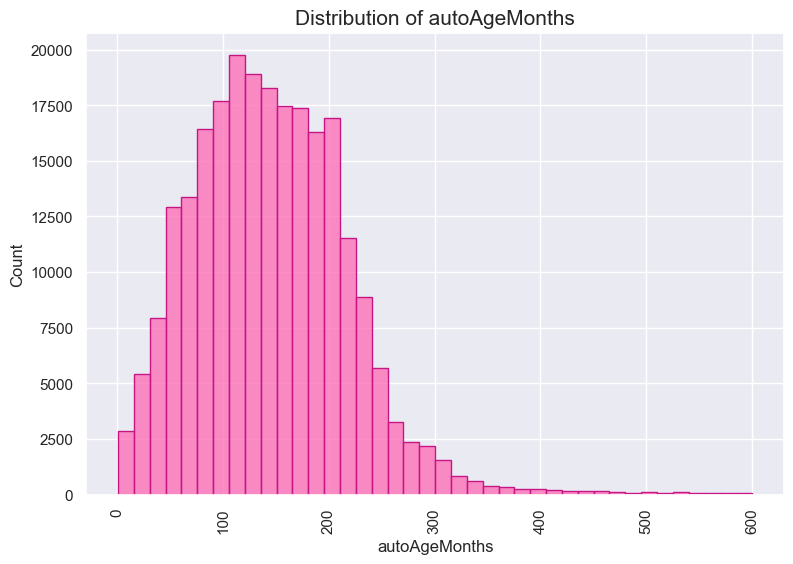

In [23]:
for feature in numeric:
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_title(f'Distribution of {feature}', fontsize=15)
    sns.histplot(data=data[feature], bins=40, ax=ax, color='hotpink', edgecolor='mediumvioletred')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

Признаков и так мало, так что никакие из них мы удалять не будем, большая часть категорий в признаках имеет разное распределение.

Выбросы есть, так что уберем их.

In [24]:
data = data[(data['log_price'] >= data['log_price'].quantile(0.01)) & (data['log_price'] <= data['log_price'].quantile(0.99))]

Можно заметить, что в данных много "right-skewed" признаков (например, powerPS). К таким признаком хорошо применяется логарифмическая трансформация. Для "left-skewed" признаков (kilometer) можно взять квадратный корень, поскольку отрицателньых значений признаков у нас тут нет.

In [25]:
data['bias'] = 1
other += ['bias']

X = data[categorical + numeric + other]
y = data['log_price']

In [26]:
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler


column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric),
    ('other',  'passthrough', other)
])

X = column_transformer.fit_transform(X)

Далее при решении задач воникают большие проблемы с индексами, они просто не идут в правильном поряде, так что мы проделаем такую штуку.

In [27]:
y.index = range(len(y))

Теперь разделим на подвыборки.

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, shuffle=True, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11, shuffle=True, random_state=42)

И снова сделаем штучку с индексами.

In [29]:
y_train.index = range(len(y_train))
y_test.index = range(len(y_test))
y_val.index = range(len(y_val))


## Задание 5. Сравнение методов градиентного спуска (2 балла)

В этом задании вам предстоит сравнить методы градиентного спуска на подготовленных вами данных из предыдущего задания.

### Задание 5.1. Подбор оптимальной длины шага (1 балл)

Подберите по валидационной выборке наилучшую длину шага $\lambda$ для каждого метода с точки зрения ошибки. Для этого сделайте перебор по логарифмической сетке. Для каждого метода посчитайте ошибку на обучающей и тестовой выборках, посчитайте качество по метрике $R^2$, сохраните количество итераций до сходимости.

Все параметры кроме `lambda_` стоит выставить равным значениям по умолчанию.

In [30]:
from sklearn.metrics import r2_score

In [32]:
logs = np.logspace(-4, 0.5, 5)
methods = ['stochastic', 'full', 'momentum', 'adam']
res_lambda = {}
iterloss = {}
rows = []
test_errs_1 = {}

descent_config = {
            'descent_name': None,
            'kwargs': {'dimension': X_train.shape[1]}
        }
for descent_name in methods:
    best_train_err = 100000000
    best_test_err = 100000000
    best_r2 = -100000000
    best_err = 100000000
    best_lambda = 1
    descent_config['descent_name'] = descent_name
    if descent_name not in test_errs_1:
        test_errs_1[descent_name] = []
    for lambda_ in logs:
        descent_config['kwargs']['lambda_'] = lambda_
        model = LinearRegression(descent_config = descent_config)
        model.fit(X_train, y_train)
        err = model.calc_loss(X_val, y_val)
        train_err = model.calc_loss(X_train, y_train)
        test_err = model.calc_loss(X_test, y_test)
        test_errs_1[descent_name].append(test_err)
        y_test_pred = model.predict(X_test)
        r2 = r2_score(model.predict(X_test), y_test)

        if err < best_err:
            best_lambda = lambda_
            best_err = err
            best_train_err = train_err
            best_test_err = test_err
            best_r2 = r2
            iterloss[descent_name] = model.loss_history
    res_lambda[descent_name] = best_lambda
    row = {
        'Method': descent_name,
        'Best Lambda': best_lambda,
        'Train MSE': best_train_err,
        'Test MSE': best_test_err,
        'Test R^2': best_r2,
        'Number of Iterations': len(iterloss[descent_name]),
    }
    rows.append(row)
results_df = pd.DataFrame(rows)
print(results_df)


       Method  Best Lambda  Train MSE  Test MSE  Test R^2  \
0  stochastic     0.237137   0.394891  0.401248  0.576480   
1        full     0.237137   0.465671  0.470918  0.542947   
2    momentum     0.237137   0.305877  0.306475  0.643427   
3        adam     3.162278   0.240388  0.248035  0.726064   

   Number of Iterations  
0                    98  
1                    34  
2                    85  
3                   178  


### Задание 5.2. Сравнение методов (1 балла)

Постройте график зависимости ошибки на обучающей выборке от номера итерации (все методы на одном графике).

Посмотрите на получившиеся результаты (таблички с метриками и график). Сравните методы между собой.

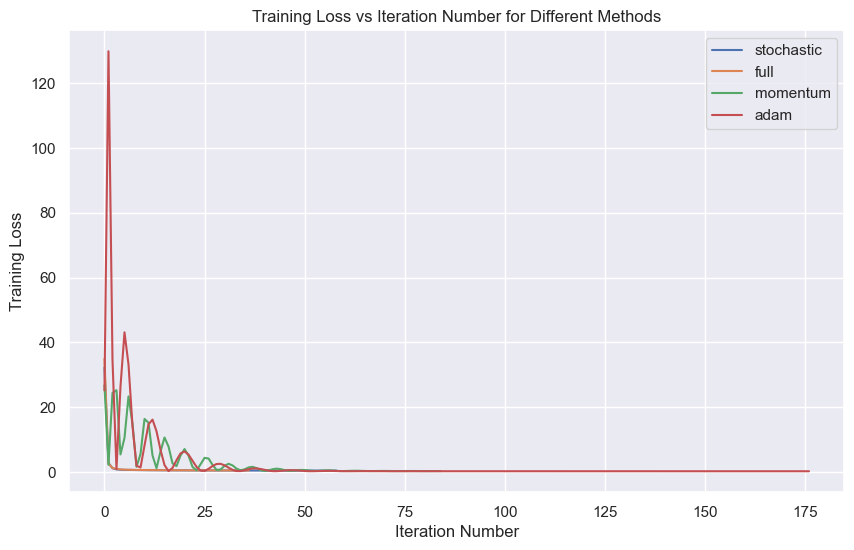

In [ ]:
plt.figure(figsize=(10, 6))
for method, losses in iterloss.items():
    plt.plot(losses, label=method)

plt.title("Training Loss vs Iteration Number for Different Methods")
plt.xlabel("Iteration Number")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

Для лучшей интерпретации переведем в логарифмическую шкалу.

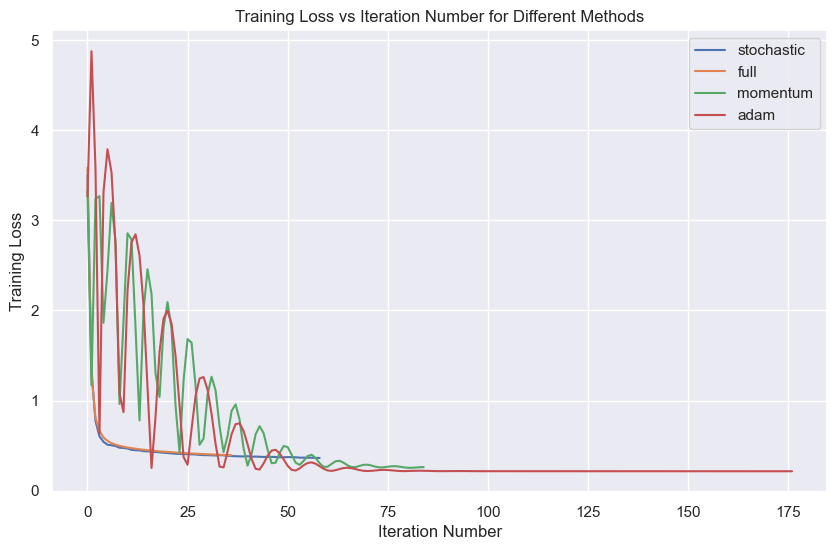

In [ ]:
plt.figure(figsize=(10, 6))
for method, losses in iterloss.items():
    plt.plot(np.log1p(losses), label=method)

plt.title("Training Loss vs Iteration Number for Different Methods")
plt.xlabel("Iteration Number")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.show()

Стохастический градиентный спуск приходит к минимуму через меньшее количество итераций, как и полный, как и ожидалось, поскольку веса обновляются после каждой итерации, при этом градиент считается не по всем объектам, что его и ускоряет. Но при этом они не достигают полного минимума. Скорее всего, они его перескакивают, потому что шаги не уменьшаются с подходом к минимуму.Наименьшую ошибку допускает адам - оно и понятно, как видно, комбинирует в себе плюсы разных способом, в том числе моментума, так что к минимуму приходит быстрее, чем он, а также он тоже менее шумный. Наименее шумный - полный градиентный спуск, потому что он считает градиент по всей выборке на каждой итерации.

## Задание 7. Регуляризация (1 балл)

В этом задании вам предстоит исследовать влияние регуляризации на работу различных методов градиентного спуска. Напомним, регуляризация - это добавка к функции потерь, которая штрафует за норму весов. Мы будем использовать l2 регуляризацию, таким образом функция потерь приобретает следующий вид:

$$
    Q(w) = \dfrac{1}{\ell} \sum\limits_{i=1}^{\ell} (a_w(x_i) - y_i)^2 + \dfrac{\mu}{2} \| w \|^2
$$

In [ ]:
class BaseDescentReg(BaseDescent):
    """
    A base class with regularization
    """

    def __init__(self, *args, mu: float = 0, **kwargs):
        """
        :param mu: regularization coefficient (float)
        """
        super().__init__(*args, **kwargs)

        self.mu = mu

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Calculate gradient of loss function and L2 regularization with respect to weights
        """
        l2_gradient = self.w 
        l2_gradient[-1] = 0
        return super().calc_gradient(x, y) + l2_gradient * self.mu

In [ ]:
class BaseDescentReg(BaseDescent):
    """
    A base class with regularization
    """

    def __init__(self, *args, mu: float = 0, **kwargs):
        """
        :param mu: regularization coefficient (float)
        """
        super().__init__(*args, **kwargs)

        self.mu = mu

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Calculate gradient of loss function and L2 regularization with respect to weights
        """
        l2_gradient = self.w 
        l2_gradient[-1] = 0
        return super().calc_gradient(x, y) + l2_gradient * self.mu


class VanillaGradientDescentReg(BaseDescentReg, VanillaGradientDescent):
    """
    Full gradient descent with regularization class
    """


class StochasticDescentReg(BaseDescentReg, StochasticDescent):
    """
    Stochastic gradient descent with regularization class
    """


class MomentumDescentReg(BaseDescentReg, MomentumDescent):
    """
    Momentum gradient descent with regularization class
    """


class AdamReg(BaseDescentReg, Adam):
    """
    Adaptive gradient algorithm with regularization class
    """


def get_descent(descent_config: dict) -> BaseDescent:
    descent_name = descent_config.get('descent_name', 'full')
    regularized = descent_config.get('regularized', False)

    descent_mapping: Dict[str, Type[BaseDescent]] = {
        'full': VanillaGradientDescent if not regularized else VanillaGradientDescentReg,
        'stochastic': StochasticDescent if not regularized else StochasticDescentReg,
        'momentum': MomentumDescent if not regularized else MomentumDescentReg,
        'adam': Adam if not regularized else AdamReg
    }

    if descent_name not in descent_mapping:
        raise ValueError(f'Incorrect descent name, use one of these: {descent_mapping.keys()}')

    descent_class = descent_mapping[descent_name]

    return descent_class(**descent_config.get('kwargs', {}))


Допишите класс **BaseDescentReg** в файле `descents.py`.

Протестируйте ваше решение в контесте.

Вставьте ссылку на успешную посылку:

* **BaseDescentReg**: https://contest.yandex.ru/contest/54610/run-report/96979387/

Найдите лучшие параметры обучения с регуляризацией аналогично 5 заданию. Будем подбирать длину шага $\lambda$ (`lambda_`) и коэффициент регуляризации $\mu$ (`mu`).

Сравните для каждого метода результаты с регуляризацией и без регуляризации (нужно опять сохранить ошибку и качество по метрике $R^2$ на обучающей и тестовой выборках и количество итераций до сходимости).

Постройте для каждого метода график со значениями функции потерь MSE с регуляризацией и без регуляризации (всего должно получиться 4 графика).

Посмотрите на получившиеся результаты. Какие можно сделать выводы, как регуляризация влияет на сходимость? Как изменилось качество на обучающей выборке? На тестовой? Чем вы можете объяснить это?

In [34]:
lambda_space = np.logspace(-4, 0.5, 5)
mu_space = np.logspace(-4, 0.5, 5)
methods = ['stochastic', 'full', 'momentum', 'adam']
best_params = {}
results = []
test_errs_2 = {}
if descent_name not in test_errs_2:
    test_errs_2[descent_name] = []
for method in methods:
    best_err = 100000000
    best_lambda = 1
    best_mu = 100000000
    best_r2 = -100000000
    best_iter = 100000000
    for lambda_ in lambda_space:
        for mu in mu_space:
            descent_config = {
                'descent_name': method,
                'regularized': True,
                'kwargs': {
                    'dimension': X_train.shape[1],
                    'lambda_': lambda_,
                    'mu': mu,
                }
            }
            model = LinearRegression(descent_config=descent_config)
            model.fit(X_train, y_train)
            val_err = model.calc_loss(X_val, y_val)
            train_err = model.calc_loss(X_train, y_train)
            test_err = model.calc_loss(X_test, y_test)
            test_errs_2[descent_name].append(test_err)
            val_r2 = r2_score(y_val, model.predict(X_val))
            test_r2 = r2_score(y_test, model.predict(X_test))
            train_r2 = r2_score(y_train, model.predict(X_train))
            if val_err < best_err:
                best_train_err = train_err
                best_test_err = test_err
                best_err = val_err
                best_lambda = lambda_
                best_mu = mu
                best_val_r2 = val_r2
                best_test_r2 = test_r2
                best_train_r2 = train_r2
                best_iter = len(model.loss_history)
    best_params[method] = (best_lambda, best_mu)
    results.append({
        'Method': method,
        'Best Lambda': best_lambda,
        'Best Mu': best_mu,
        'Test MSE': best_test_err,
        'Train MSE': best_train_err,
        'Test R2': best_test_r2,
        'Train R2': best_train_r2,
        'Validation MSE': best_err,
        'Validation R^2': r2,
        'Iterations': best_iter
    })
results_df = pd.DataFrame(results)
print(results_df)

       Method  Best Lambda   Best Mu  Test MSE  Train MSE   Test R2  Train R2  \
0  stochastic     0.237137  0.001334  0.420682   0.419038  0.629805  0.630854   
1        full     0.237137  0.017783  0.479928   0.475503  0.577668  0.581112   
2    momentum     0.237137  0.017783  0.291521   0.285033  0.743464  0.748904   
3        adam     3.162278  0.000100  0.249145   0.241462  0.780755  0.787287   

   Validation MSE  Validation R^2  Iterations  
0        0.428566        0.726064         131  
1        0.478002        0.726064          56  
2        0.291821        0.726064         301  
3        0.248992        0.726064         301  


## Задание 8. Альтернативная функция потерь (1 балл)

В этом задании вам предстоит использовать другую функцию потерь для нашей задачи регрессии. В качестве функции потерь мы выбрали **Log-Cosh**:

$$
    L(y, a)
    =
    \log\left(\cosh(a - y)\right).
$$


Самостоятельно продифференцируйте данную функцию потерь чтобы найти её градиент:
$$
L(y, a) = \log(\cosh(a - y)) \\ \\
\frac{dL}{da} = \frac{1}{cosh(a - y)} \frac{d}{da}(cosh(a-y)) = \\ \\
= \frac{1}{cosh(a - y)} \sinh(a-y)\\ \\

\frac{dL}{da} = \frac{\sinh(a - y)}{\cosh(a - y)}
$$

Программно реализуйте градиентный спуск с данной функцией потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Пример того, как можно запрограммировать использование нескольких функций потерь внутри одного класса градиентного спуска:


```python
from enum import auto
from enum import Enum

import numpy as np

class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()

...
class BaseDescent:
    def __init__(self, loss_function: LossFunction = LossFunction.MSE):
        self.loss_function: LossFunction = loss_function

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function is LossFunction.MSE:
            return ...
        elif self.loss_function is LossFunction.LogCosh:
            return ...
...

```

In [ ]:
from dataclasses import dataclass
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type

import numpy as np


@dataclass
class LearningRate:
    lambda_: float = 1e-3
    s0: float = 1
    p: float = 0.5

    iteration: int = 0

    def __call__(self):
        """
        Calculate learning rate according to lambda (s0/(s0 + t))^p formula
        """
        self.iteration += 1
        return self.lambda_ * (self.s0 / (self.s0 + self.iteration)) ** self.p


class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()


class BaseDescent:
    """
    A base class and templates for all functions
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Template for update_weights function
        Update weights with respect to gradient
        :param gradient: gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        pass

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Template for calc_gradient function
        Calculate gradient of loss function with respect to weights
        :param x: features array
        :param y: targets array
        :return: gradient: np.ndarray
        """
        pass

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        if self.loss_function == LossFunction.LogCosh:
            return np.mean(np.log(np.cosh(x @ self.w - y)))
        elif self.loss_function == LossFunction.MSE:
            return np.mean(np.square(y - x @ self.w))

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        y_pred = x @ self.w
        return y_pred

In [ ]:
class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        weight_difference = -self.lr() * gradient
        self.w += weight_difference
        return weight_difference

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function == LossFunction.MSE:
            gradient = (2 / x.shape[0]) * (x.T.dot(x.dot(self.w) - y))
        elif self.loss_function == LossFunction.LogCosh:
            error = x.dot(self.w) - y
            gradient = np.sinh(error) / np.cosh(error)
        return gradient

In [ ]:
class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        indices = np.random.choice(range(len(y)), size=self.batch_size, replace=False)
        x_batch = x[indices]
        y_batch = y[indices]
        if self.loss_function == LossFunction.MSE:
            gradient = (2 / self.batch_size) * x_batch.T.dot(x_batch.dot(self.w) - y_batch)
        elif self.loss_function == LossFunction.LogCosh:
            error = x_batch.dot(self.w) - y_batch
            gradient = np.sinh(error) / np.cosh(error)
        return gradient

In [ ]:
class MomentumDescent(VanillaGradientDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.h = self.alpha * self.h - self.lr() * gradient
        weight_difference = self.h
        self.w += weight_difference
        return weight_difference

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function == LossFunction.MSE:
            gradient = (2 / x.shape[0]) * (x.T.dot(x.dot(self.w) - y))
        elif self.loss_function == LossFunction.LogCosh:
            error = x.dot(self.w) - y
            gradient = np.sinh(error) / np.cosh(error)
        return gradient

In [ ]:
class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.iteration += 1
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradient
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * np.square(gradient)
        m_hat = self.m / (1 - self.beta_1 ** self.iteration)
        v_hat = self.v / (1 - self.beta_2 ** self.iteration)
        weight_difference = - (self.lr() / (np.sqrt(v_hat) + self.eps)) * m_hat
        self.w += weight_difference
        return weight_difference

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function == LossFunction.MSE:
            gradient = (2 / x.shape[0]) * (x.T.dot(x.dot(self.w) - y))
        elif self.loss_function == LossFunction.LogCosh:
            error = x.dot(self.w) - y
            gradient = np.sinh(error) / np.cosh(error)
        return gradient

In [ ]:
logs = np.logspace(-4, 0.5, 5)
methods = ['stochastic', 'full', 'momentum', 'adam']
res_lambda = {}
iterloss = {}
rows = []
descent_config = {
            'descent_name': None,
            'kwargs': {'dimension': X_train.shape[1]}
        }
for descent_name in methods:
    best_train_err = 100000000
    best_test_err = 100000000
    best_r2 = -100000000
    best_err = 100000000
    best_lambda = 1
    descent_config['descent_name'] = descent_name
    for lambda_ in logs:
        descent_config['kwargs']['lambda_'] = lambda_
        model = LinearRegression(descent_config = descent_config)
        model.fit(X_train, y_train)
        err = model.calc_loss(X_val, y_val)
        train_err = model.calc_loss(X_train, y_train)
        test_err = model.calc_loss(X_test, y_test)
        y_test_pred = model.predict(X_test)
        r2 = r2_score(model.predict(X_test), y_test)
        if err < best_err:
            best_lambda = lambda_
            best_err = err
            best_train_err = train_err
            best_test_err = test_err
            best_r2 = r2
            iterloss[descent_name] = model.loss_history
    res_lambda[descent_name] = best_lambda
    row = {
        'Method': descent_name,
        'Best Lambda': best_lambda,
        'Train MSE': best_train_err,
        'Test MSE': best_test_err,
        'Test R^2': best_r2,
        'Number of Iterations': len(iterloss[descent_name]),
    }
    rows.append(row)
results_df = pd.DataFrame(rows)
print(results_df)

       Method  Best Lambda  Train MSE  Test MSE  Test R^2  \
0  stochastic     0.237137   0.424558  0.429789  0.534795   
1        full     0.237137   0.477859  0.487086  0.525125   
2    momentum     0.237137   0.302739  0.305418  0.633122   
3        adam     3.162278   0.240378  0.248100  0.726024   

   Number of Iterations  
0                    82  
1                    36  
2                    85  
3                   187  


Качество улучшилось везде, кроме моментума. Тут оно ухудшилось.

### Кулинарно-социализационный бонус. (0.5 балла).

Как мы знаем, осень прекрасная пора, время пробовать новое и делиться теплом с друзьями и близкими. Выберите рецепт, который соответствует вашему настроению, приготовьте выбранное блюдо и угостите хотя бы одного человека им. Кратко опишите ваши впечатления, прикрепите рецепт и фотографии блюда и довольного гостя.

Рецепт был взят и кондитерского курса Pauline Cake: https://paulinecakeclub.ru/kapkejki-vanilnye/ 
Я приготовила ванильные капкейки с вишневой начинкой, пошла в гости к своей подруге лере и привезла ей шесть штук! Потому что она очень стройная.

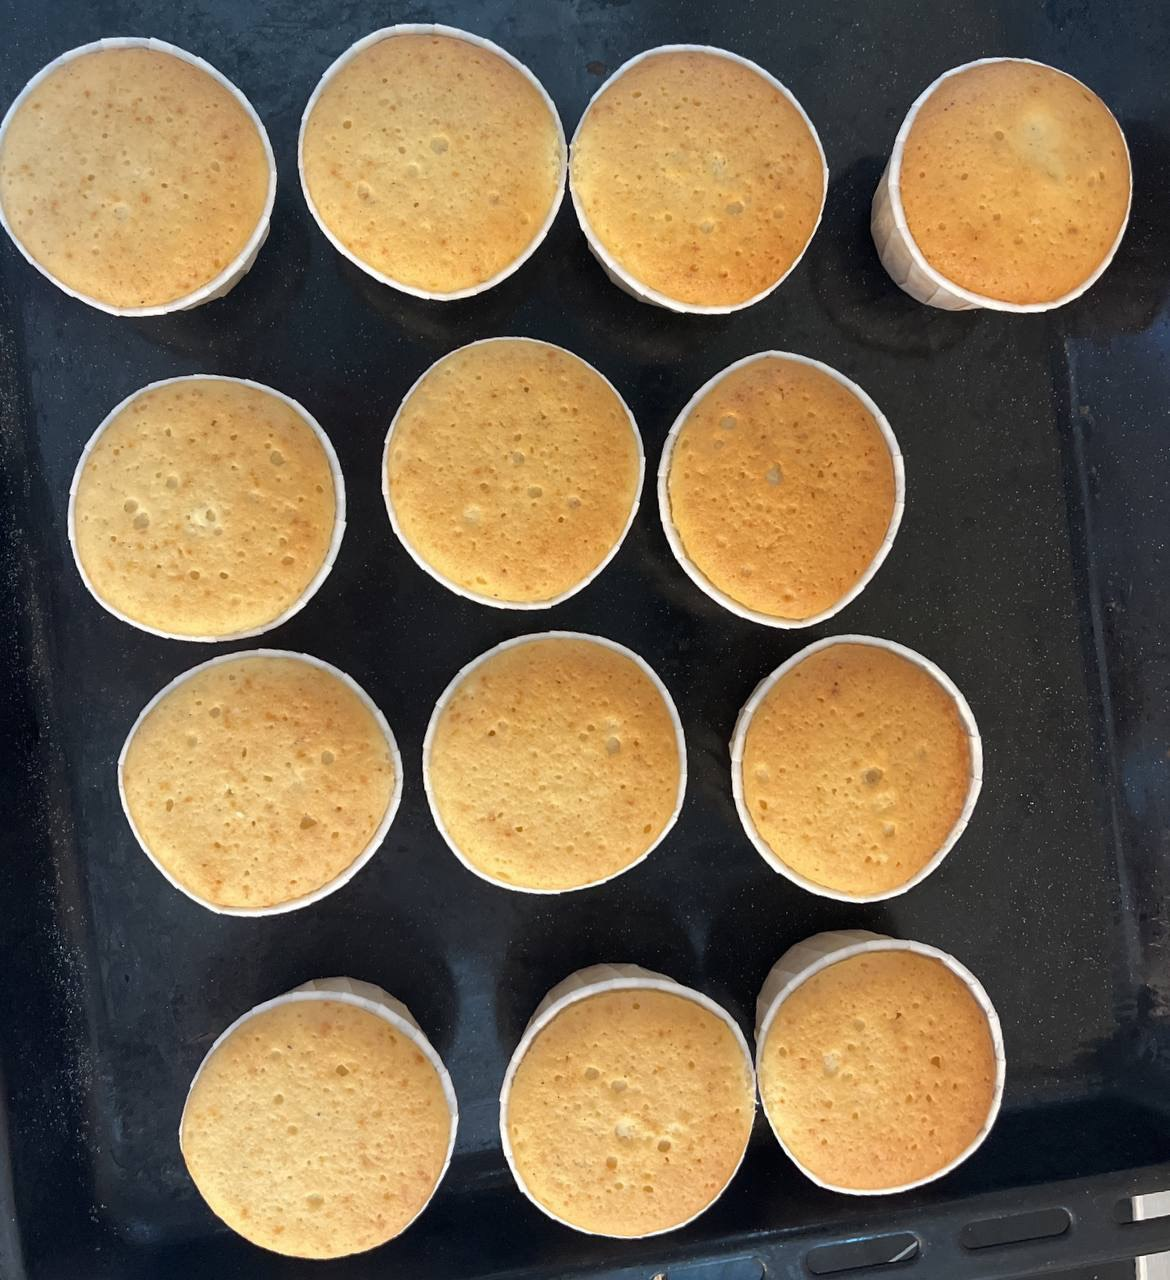 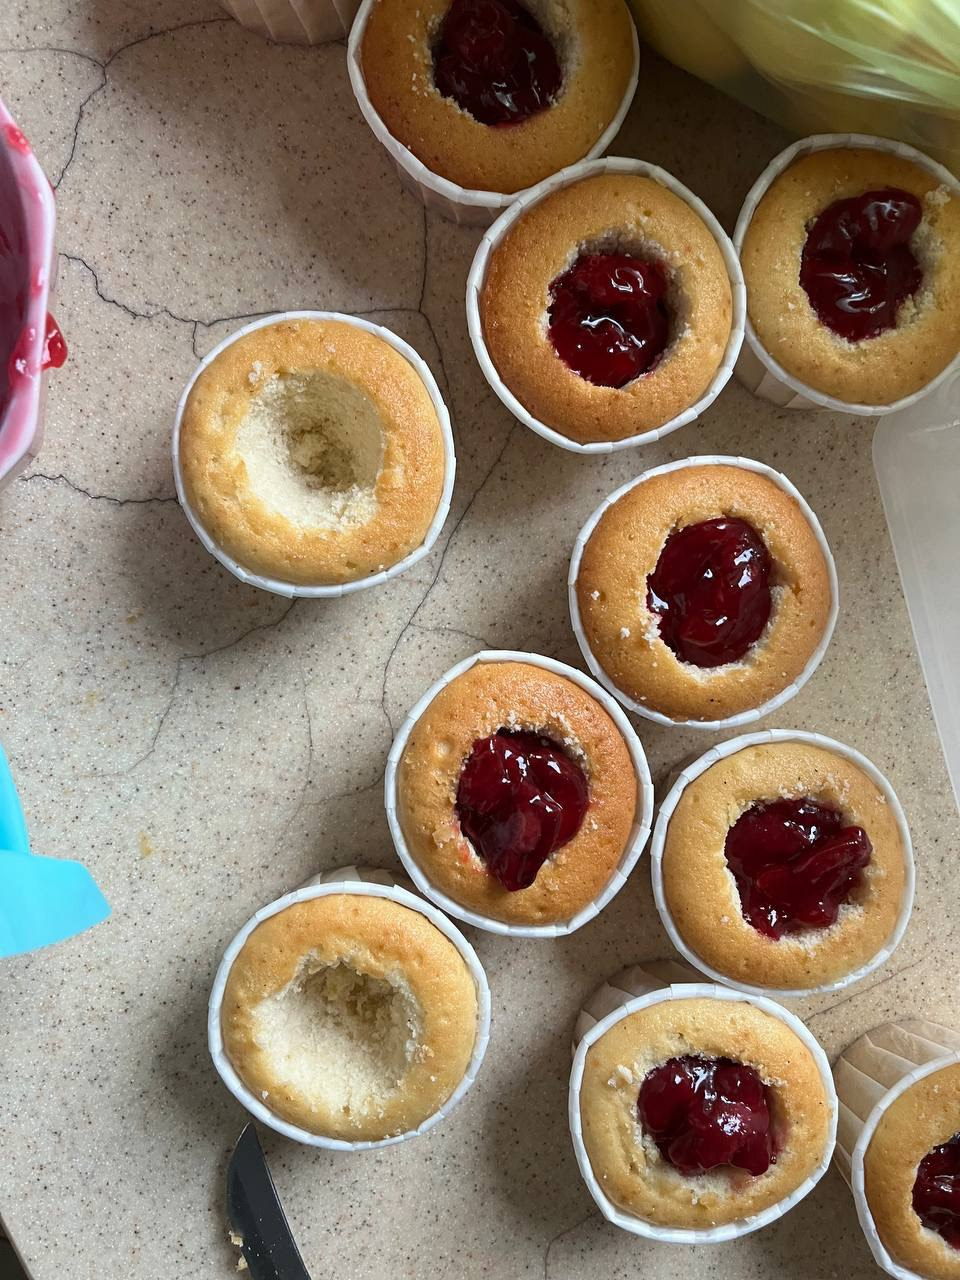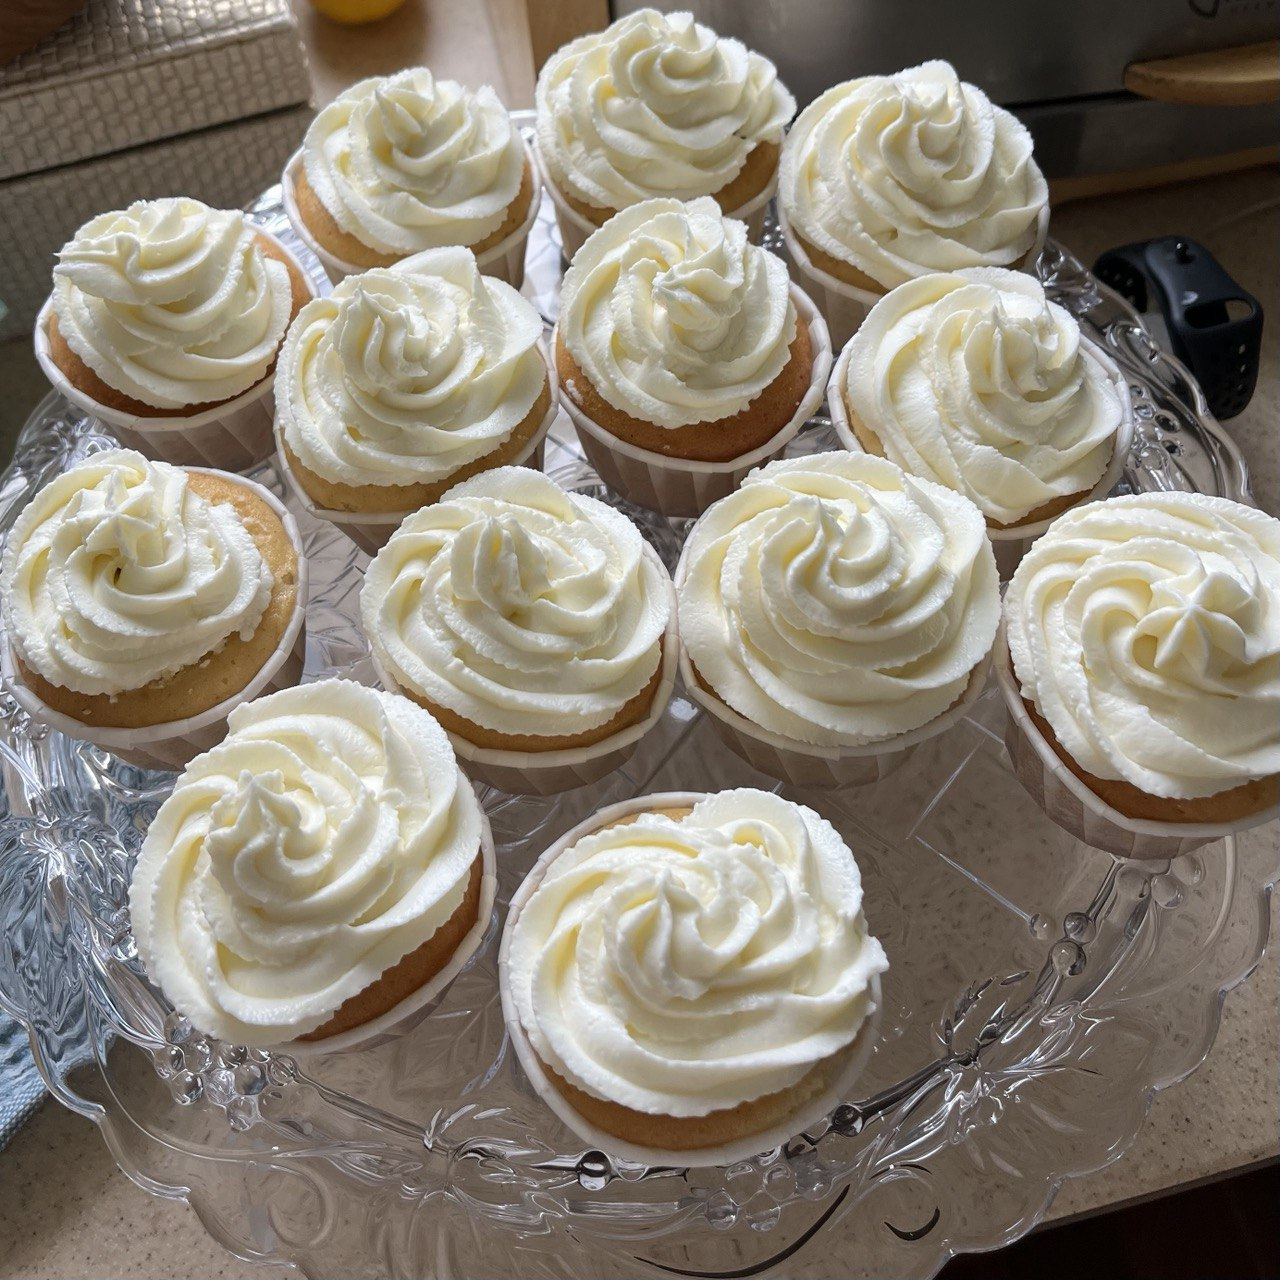

Здесь мы едим капкейки, Лера просила ее не снимать, тут мы занимались эконометрикой.

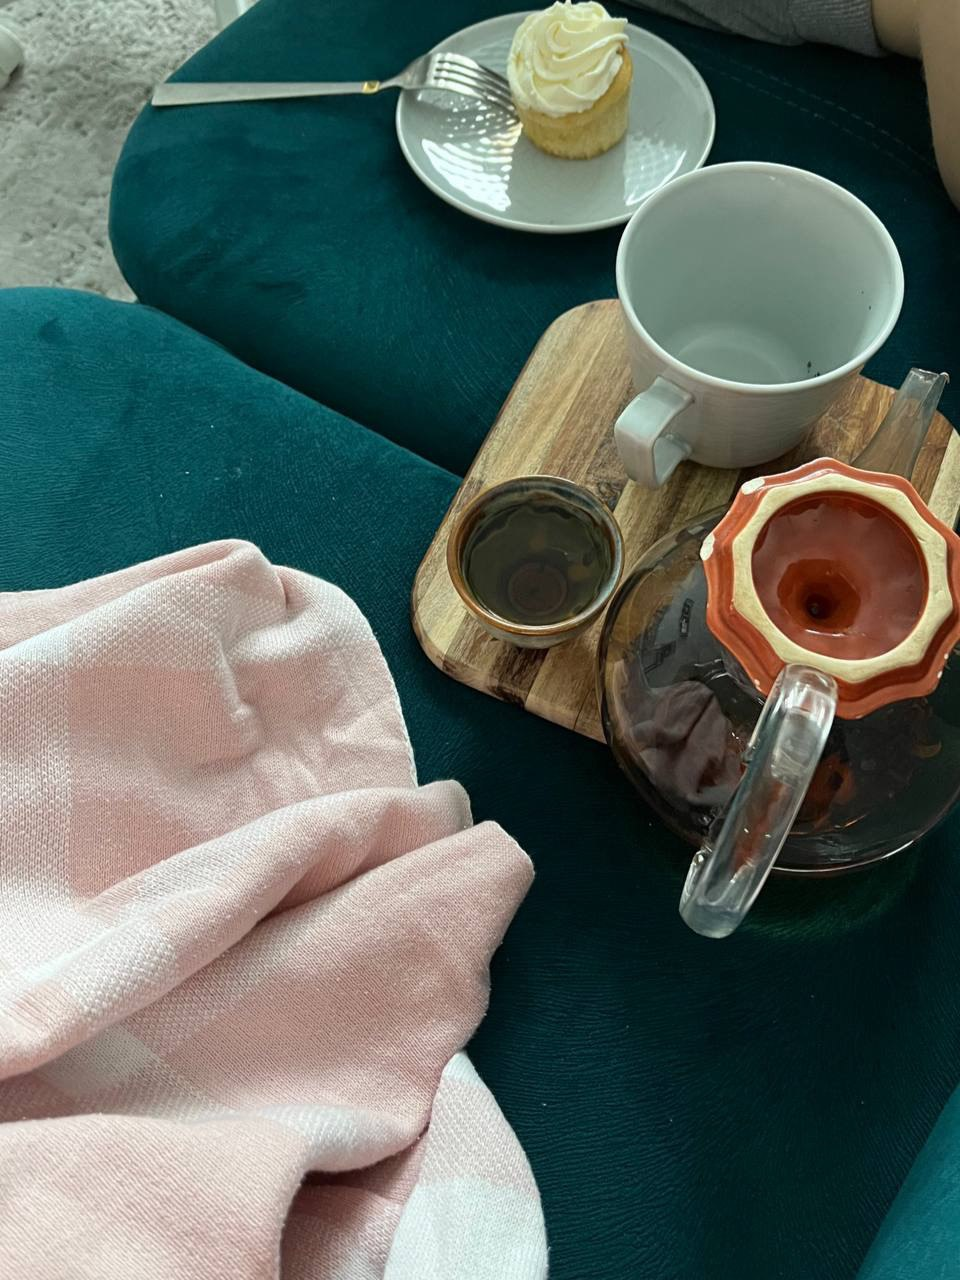

И вот фото довольного гостя (Скрин кружка в телеграме)))):

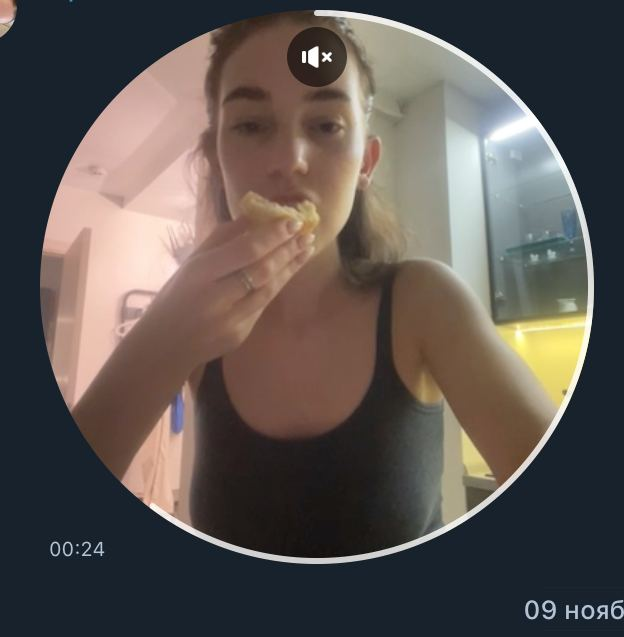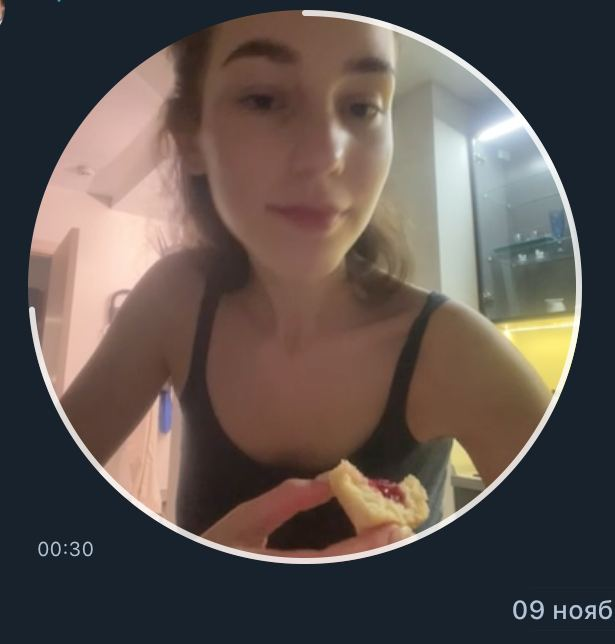

Впечатления очень хорошие,кексы были очень вкусные, но я бы лучше съела шоколадные. Лера шоколадные не любит.

### Бонус 1. Другие методы градиентного спуска (1 балл).

По желанию выберите метод градиентного спуска из следующего списка и самостоятельно реализуйте его в файле `descents.py`. Обучите линейную регрессию с помощью этого метода, сравните с методами из основной части домашнего задания.

`AMSGrad` (ещё одна вариация Adam).

\begin{align}
    &m_0 = 0, \quad v_0 = 0; \\ \\
    &m_{k + 1} = \beta_1 m_k + (1 - \beta_1) \nabla_w Q(w_{k}); \\ \\
    &v_{k + 1} = \beta_2 v_k + (1 - \beta_2) \left(\nabla_w Q(w_{k})\right)^2; \\ \\
    &\widehat{v}_{k+1} = \ max({v}_{k+1}, \widehat{v}_{k})\\
    &w_{k + 1} = w_{k} - \dfrac{\eta_k}{\sqrt{\widehat{v}_{k + 1}} + \varepsilon} {m}_{k + 1}.
\end{align}

In [ ]:
class AMSGrad(VanillaGradientDescent):
    """
    AMSGrad gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)
        self.v_hat: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.iteration += 1
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradient
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * np.square(gradient)
        self.v_hat = np.maximum(self.v_hat, self.v)
        weight_difference = - (self.lr() / (np.sqrt(self.v_hat) + self.eps)) * self.m
        self.w += weight_difference
        return weight_difference


### Бонус 2. Другие функции потерь (1 балл).

Аналогично 8 заданию реализуйте две функции потерь - **MAE** и **Huber**.

Самостоятельно продифференцируйте данные функции потерь, чтобы найти их градиенты:
\begin{align}
MAE = \frac{1}{n} \sum |y_i - \widehat{y}_i|\\
\frac{\partial MAE}{\partial \widehat{y}_i} = \frac{1}{n} sign(\widehat{y}_i - y_i)
\end{align}

\begin{align}
L = 
\begin{cases}
\frac{1}{2} a^2 & \text{if } |a| \le \delta \\
\delta (|a| - \frac{1}{2} \delta) & \text{otherwise}
\end{cases} \\
\frac{\partial L(a)}{\partial f(x)} = 
\begin{cases}
-a & \text{if } |a| \le \delta \\
-\delta \cdot \text{sign}(a) & \text{otherwise}
\end{cases}

\end{align}

Программно реализуйте градиентный спуск с данными функциями потерь в файле `descents.py`, обучите все четыре метода (без регуляризации) аналогично 5 заданию, сравните их качество с четырьмя методами из 5 задания.

Сравните между собой *для каждого метода отдельно* качество для разных функций потерь. Какая оказалась лучше? Как вы думаете почему?

In [ ]:
@dataclass
class LearningRate:
    lambda_: float = 1e-3
    s0: float = 1
    p: float = 0.5

    iteration: int = 0

    def __call__(self):
        """
        Calculate learning rate according to lambda (s0/(s0 + t))^p formula
        """
        self.iteration += 1
        return self.lambda_ * (self.s0 / (self.s0 + self.iteration)) ** self.p


class LossFunction(Enum):
    MSE = auto()
    MAE = auto()
    LogCosh = auto()
    Huber = auto()



class BaseDescent:
    """
    A base class and templates for all functions
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        """
        :param dimension: feature space dimension
        :param lambda_: learning rate parameter
        :param loss_function: optimized loss function
        """
        self.w: np.ndarray = np.random.rand(dimension)
        self.lr: LearningRate = LearningRate(lambda_=lambda_)
        self.loss_function: LossFunction = loss_function

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.calc_gradient(x, y))

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        Template for update_weights function
        Update weights with respect to gradient
        :param gradient: gradient
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        pass

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        """
        Template for calc_gradient function
        Calculate gradient of loss function with respect to weights
        :param x: features array
        :param y: targets array
        :return: gradient: np.ndarray
        """
        pass

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        """
        Calculate loss for x and y with our weights
        :param x: features array
        :param y: targets array
        :return: loss: float
        """
        if self.loss_function == LossFunction.LogCosh:
            return np.mean(np.log(np.cosh(x @ self.w - y)))
        elif self.loss_function == LossFunction.MSE:
            return np.mean(np.square(y - x @ self.w))

    def predict(self, x: np.ndarray) -> np.ndarray:
        """
        Calculate predictions for x
        :param x: features array
        :return: prediction: np.ndarray
        """
        y_pred = x @ self.w
        return y_pred


class VanillaGradientDescent(BaseDescent):
    """
    Full gradient descent class
    """

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        weight_difference = -self.lr() * gradient
        self.w += weight_difference
        return weight_difference

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function == LossFunction.MSE:
            gradient = (2 / x.shape[0]) * (x.T.dot(x.dot(self.w) - y))
        elif self.loss_function == LossFunction.LogCosh:
            error = x.dot(self.w) - y
            gradient = np.sinh(error) / np.cosh(error)
        elif self.loss_function == LossFunction.MAE:
            error = x.dot(self.w) - y
            gradient = (1 / x.shape[0]) * np.sign(error)
        elif self.loss_function == LossFunction.Huber:
            error = x.dot(self.w) - y
            delta = 1
            gradient = np.where(np.abs(error) <= delta, -error, -delta * np.sign(error))
        return gradient


class StochasticDescent(VanillaGradientDescent):
    """
    Stochastic gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, batch_size: int = 50,
                 loss_function: LossFunction = LossFunction.MSE):
        """
        :param batch_size: batch size (int)
        """
        super().__init__(dimension, lambda_, loss_function)
        self.batch_size = batch_size

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function == LossFunction.MSE:
            gradient = (2 / self.batch_size) * x.T.dot(x.dot(self.w) - y)
        elif self.loss_function == LossFunction.LogCosh:
            error = x.dot(self.w) - y
            gradient = np.sinh(error) / np.cosh(error)
        elif self.loss_function == LossFunction.MAE:
            error = x.dot(self.w) - y
            gradient = (1 / self.batch_size) * np.sign(error)
        elif self.loss_function == LossFunction.Huber:
            error = x.dot(self.w) - y
            delta = 1
            gradient = np.where(np.abs(error) <= delta, -error, -delta * np.sign(error))
        return gradient


class MomentumDescent(VanillaGradientDescent):
    """
    Momentum gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.alpha: float = 0.9

        self.h: np.ndarray = np.zeros(dimension)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.h = self.alpha * self.h - self.lr() * gradient
        weight_difference = self.h
        self.w += weight_difference
        return weight_difference

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function == LossFunction.MSE:
            gradient = (2 / x.shape[0]) * (x.T.dot(x.dot(self.w) - y))
        elif self.loss_function == LossFunction.LogCosh:
            error = x.dot(self.w) - y
            gradient = np.sinh(error) / np.cosh(error)
        elif self.loss_function == LossFunction.MAE:
            error = x.dot(self.w) - y
            gradient = (1 / x.shape[0]) * np.sign(error)
        elif self.loss_function == LossFunction.Huber:
            error = x.dot(self.w) - y
            delta = 1
            gradient = np.where(np.abs(error) <= delta, -error, -delta * np.sign(error))
        return gradient


class Adam(VanillaGradientDescent):
    """
    Adaptive Moment Estimation gradient descent class
    """

    def __init__(self, dimension: int, lambda_: float = 1e-3, loss_function: LossFunction = LossFunction.MSE):
        super().__init__(dimension, lambda_, loss_function)
        self.eps: float = 1e-8

        self.m: np.ndarray = np.zeros(dimension)
        self.v: np.ndarray = np.zeros(dimension)

        self.beta_1: float = 0.9
        self.beta_2: float = 0.999

        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        """
        :return: weight difference (w_{k + 1} - w_k): np.ndarray
        """
        self.iteration += 1
        self.m = self.beta_1 * self.m + (1 - self.beta_1) * gradient
        self.v = self.beta_2 * self.v + (1 - self.beta_2) * np.square(gradient)
        m_hat = self.m / (1 - self.beta_1 ** self.iteration)
        v_hat = self.v / (1 - self.beta_2 ** self.iteration)
        weight_difference = - (self.lr() / (np.sqrt(v_hat) + self.eps)) * m_hat
        self.w += weight_difference
        return weight_difference

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        if self.loss_function == LossFunction.MSE:
            gradient = (2 / x.shape[0]) * (x.T.dot(x.dot(self.w) - y))
        elif self.loss_function == LossFunction.LogCosh:
            error = x.dot(self.w) - y
            gradient = np.sinh(error) / np.cosh(error)
        elif self.loss_function == LossFunction.MAE:
            error = x.dot(self.w) - y
            gradient = (1 / x.shape[0]) * np.sign(error)
        elif self.loss_function == LossFunction.Huber:
            error = x.dot(self.w) - y
            delta = 1
            gradient = np.where(np.abs(error) <= delta, -error, -delta * np.sign(error))
        return gradient



In [ ]:
logs = np.logspace(-4, 0.5, 5)
methods = ['stochastic', 'full', 'momentum', 'adam']
res_lambda = {}
iterloss = {}
rows = []
descent_config = {
            'descent_name': None,
            'kwargs': {'dimension': X_train.shape[1]}
        }
for descent_name in methods:
    best_train_err = 100000000
    best_test_err = 100000000
    best_r2 = -100000000
    best_err = 100000000
    best_lambda = 1
    descent_config['descent_name'] = descent_name
    for lambda_ in logs:
        descent_config['kwargs']['lambda_'] = lambda_
        model = LinearRegression(descent_config = descent_config)
        model.fit(X_train, y_train)
        err = model.calc_loss(X_val, y_val)
        train_err = model.calc_loss(X_train, y_train)
        test_err = model.calc_loss(X_test, y_test)
        y_test_pred = model.predict(X_test)
        r2 = r2_score(model.predict(X_test), y_test)
        if err < best_err:
            best_lambda = lambda_
            best_err = err
            best_train_err = train_err
            best_test_err = test_err
            best_r2 = r2
            iterloss[descent_name] = model.loss_history
    res_lambda[descent_name] = best_lambda
    row = {
        'Method': descent_name,
        'Best Lambda': best_lambda,
        'Train MSE': best_train_err,
        'Test MSE': best_test_err,
        'Test R^2': best_r2,
        'Number of Iterations': len(iterloss[descent_name]),
    }
    rows.append(row)
results_df = pd.DataFrame(rows)
print(results_df)

       Method  Best Lambda  Train MSE  Test MSE  Test R^2  \
0  stochastic     0.237137   0.441581  0.447308  0.549353   
1        full     0.237137   0.491202  0.493690  0.533330   
2    momentum     0.237137   0.298915  0.303164  0.639921   
3        adam     3.162278   0.240579  0.248323  0.725934   

   Number of Iterations  
0                    98  
1                    30  
2                    85  
3                   183  
